## A) Imports and data loading

In [ ]:
!pip install pandas==1.0.5

In [ ]:
!pip install plotly==5.4.0

     |████████████████████████████████| 25.3 MB 1.7 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [ ]:
!pip install tld

     |████████████████████████████████| 412 kB 6.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import bz2
import json
import csv
import copy
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
from ast import literal_eval
import urllib.request as ul
from collections import Counter
from tld import get_fld
import string
import os
import nltk
from statsmodels.stats.weightstats import DescrStatsW
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



nltk.download('stopwords')
nltk.download("punkt")
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('crubadan')

from nltk.sentiment import SentimentIntensityAnalyzer  # VADER is better for short sentences, but we only have this so we use just that.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

drive = '/content/drive/MyDrive/ADA-shared/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package crubadan to /root/nltk_data...
[nltk_data]   Package crubadan is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
pd.__version__

'1.0.5'

### Load *Wikidata* data dumps



In [ ]:
# Load the speaker attributes 
wikidata_speakers = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet')

In [ ]:
wikidata_speakers.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3100554,None,None,None,[Q6581072],1362577267,None,None,[Q1650915],None,None,Q89165695,Maria Alice Muniz Domingos,None,item,None
4892933,None,[+1893-02-18T00:00:00Z],None,[Q6581097],1319290922,None,None,[Q13414980],None,None,Q21070142,Phil Furlong,None,item,None
5891182,"[Koho Kato, Kouhou Katou]",[+1934-05-01T00:00:00Z],[Q17],[Q6581097],1328439226,None,None,None,None,None,Q11399025,Kōhō Katō,None,item,None
241527,None,[+0850-00-00T00:00:00Z],None,[Q6581097],1395745927,None,None,None,None,None,Q11623247,None,None,item,None
3588781,None,[+1872-01-01T00:00:00Z],None,[Q6581097],1319235270,None,None,[Q482980],None,None,Q7147500,Patrick R. Chalmers,None,item,None


#### Load the human interpretable labels

In [ ]:
path_to_file = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
# Directly use the built-in pandas function as the CSV is quite small 
df_labels_wiki = pd.read_csv(path_to_file,  encoding='utf-8', compression="bz2")
df_labels_wiki.head(5)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


The function `retrieve_wikidata_properties` simply returns the wikidata properties of the given person.

In [ ]:
def retrieve_wikidata_properties(person):
  # This function simply returns the wikidata properties of the given person
  return wikidata_speakers[wikidata_speakers["id"]==person]

The function `human_readable_properties` converts the QIDs into human readable format.

In [ ]:
def human_readable_properties(data, property):
  list_QID = (data.iloc[0][property])
  list_values = []
  # Start by testing whether there is value
  if not(list_QID is None):
    # As there might be several values per property, we iterate on them
    for idx, QID in enumerate(list_QID):
      # Check whether the QID is corrupted, i.e. do not start by Q or less than two characters 
      if len(QID) >= 2 and QID[0] == 'Q':
        # Retrieve the Label (not description) of the QID item in the dataframe containing wikidata label
        # In df_labels_wiki, select the row that corresponds to the QID of interst 
        selector = df_labels_wiki["QID"] == QID 
        # Then extract the label of the QID/item of interest
        list_values.append(df_labels_wiki[selector].iloc[0]["Label"])
      else:
        warnings.warn("This is a corrupted QID, no value is returned!")
    return list_values
  else:
    warnings.warn("There is no value for this property!")
    return None  

A function that is used several times in sections D, E, it is easier to define it here.

In [ ]:
def load_csv_to_df(year, domain, folder="News_outlet_csvs"):
    path = os.path.join(drive, folder, str(year), str(year) + "_" + domain + ".csv")
    outlet_df = pd.read_csv(path, encoding="utf-8")
    return outlet_df

## B) Data exploration

Here we explore the data and check what kind of issues we could face later during the handling of the data. 

We will start by a basic visualisation of the dataset: check how the quotes look like.

In [ ]:
# Load & format quotes from 2020
path_to_file = drive + 'Quotebank/quotes-2020.json.bz2' 

list_of_quotes_dict = []
count = 0
sample_size = 10000  # Sample chosen for current experiments

# Open the 2020 quotebank
with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        if count == sample_size:
            break
        #print(instance)
        decoded = json.loads(instance.decode('utf-8'))  # Decode each instance into a dictionary
        #print(decoded["quoteID"])
        list_of_quotes_dict.append(decoded)
        count += 1

df_quotes = pd.DataFrame(list_of_quotes_dict)  # Turn list of entries into dataframe
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


### 1) Frequency of domains

We want to compute the number of quotes per news outlet in order to choose the most important for our analysis.

The first step is to extract the domain from the url. For this task we use the *tld* library.

The `get_domain` function return the domain name from an url.

Example: `get_domain("https://stackoverflow.com/questions/ ")` returns *stackoverflow.com*

The `domain_counting` function takes the list of urls of one quotes and count the number of domains using `get_domain` and the function `Counter` from the library Collection.

In [ ]:
def get_domain(url):
    return get_fld(url)

def domain_counting(urls):
    domain_list = [get_domain(url) for url in urls] #we store the domain in this list
    return Counter(domain_list)

We now count the number of quotes per news outlet per year and save this data to external csv files, such that we can easily access them again. This code takes a long time to run and, in practice, was run in parallel on several machines to save some time.

In [ ]:
def count_domains_per_year():

    path_domains_count = drive + "Domains_count/"
    if not os.path.exists(path_domains_count):
        os.makedirs(path_domains_count)

    years = range(2015, 2021)

    for year in years:

        path_to_file = drive + 'Quotebank/quotes-'+ str(year) + '.json.bz2' 
        domains_count = Counter()
        iterations_counter = 0
        df_test = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100, encoding="utf-8") #code used to load the data by chunks

        for chunk in df_test:

            if iterations_counter % 1000 == 0:
                print("Processing chunk", iterations_counter, "of year", year)

            domains = chunk['urls'].apply(domain_counting)
            domains_count = domains_count + domains.sum() # chunk['urls'].apply(..) return a series containing the result of Counter(domain_list), so we have to use .sum() to obtain a Counter object.
            iterations_counter += 1

            if iterations_counter % 10000 == 0:
                # Write domains to file every 1 million quotes as intermediate backup in case colab decides to stop running
                print("Processing chunk " + str(iterations_counter) + " of year " + str(year) + "...")
                ordered_domains_count_list = domains_count.most_common()
                filename = path_domains_count + "domains_count_" + str(year) + "_" + str(iterations_counter) + ".csv"
                with open(filename, 'w') as f:
                    for dom, c in ordered_domains_count_list:
                        f.write("{},{}\n".format(dom, c))
                    f.close()

                print("Saved domains count for year " + str(year) + " chunks " + str(iterations_counter))

        # Write final count to file
        ordered_domains_count_list = domains_count.most_common()
        filename = path_domains_count + "domains_count_" + str(year) + "_final.csv"
        with open(filename, 'w') as f:
            for dom, c in ordered_domains_count_list:
                f.write("{},{}\n".format(dom, c))
            f.close()

        print("Saved final domains count for year " + str(year))


In [ ]:
# To execute the function, do not run it a second time! 
#count_domains_per_year()

### 2) Selection of news outlets to analyse

Now that we have the count of quotes for each individual news outlet, we want to select which outlets we will study in our analysis, as studying them all is impossible for us in terms of time and resources.

When selecting the outlets, we take the following concerns into consideration:

1. We are likely to observe different quoting patterns for non-American outlets than for American ones due to cultural factors, and we may not have the required knowledge to analyse them properly, but it can be interesting to observe these differences during analysis.
2. We want the news outlets we choose to be comparable in terms of amount of data we have per outlet per year. For this reason, we select outlets among those that have many quotes in every single year.
3. Some news outlets are actually not creating new content, but instead repost/share news from several news outlets on their website. Due to this fact, these outlets cannot be compared with standard news outlets. However, it can still be interesting to analyse them separately.

To ensure that point 2 is satisfied, we decide to analyse only outlets that are in the top X news outlets with the most quotes in every single year. We choose X = 200, which returns a total of 36 news outlets to analyse. This additionally is convenient for us, as we are strongly constrained in terms of time and resources and want to reduce the amount of data to analyse.

As for point 1 and 3, we create a csv file with all news outlets selected and manually label their country of origin and whether they are creating new content or reposting existing articles. This way, we can easily access this information during our analysis.

In [ ]:
def select_common_top_X_doms(X, stats=False):
    '''Select news outlets that occur in all the top X counts of quotes of each year.'''
    
    # Path to folder containing the domains count per year
    path_domains_count = drive + "Domains_count/"
    column_names = ["Domain name", "count"]

    # Loading the counts to dataframes, sorting the counts and keeping only the top X counts of each year
    domains_count_2015 = pd.read_csv(path_domains_count + "domains_count_2015_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2016 = pd.read_csv(path_domains_count + "domains_count_2016_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2017 = pd.read_csv(path_domains_count + "domains_count_2017_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2018 = pd.read_csv(path_domains_count + "domains_count_2018_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2019 = pd.read_csv(path_domains_count + "domains_count_2019_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2020 = pd.read_csv(path_domains_count + "domains_count_2020_final.csv", names=column_names).sort_values("count", ascending=False).head(X)

    # get the set of domains of each year and intersect them with each other to only keep those that occur in all years
    all_doms_df = [domains_count_2015, domains_count_2016, domains_count_2017, domains_count_2018, domains_count_2019, domains_count_2020]
    doms = [set(dom["Domain name"]) for dom in all_doms_df]
    common_domains = doms[0].intersection(*doms)

    # Some quick stats for our own curiosity
    if stats:
        years = range(2015, 2021)
        print("Some stats of results for X =", X, "\n")
        for i, dom in enumerate(all_doms_df):
            print("Year:", years[i])
            maximum = dom["count"].iloc[0]
            minimum = dom["count"].iloc[-1]
            print("Max", maximum)
            print("Min", minimum)
            print("Difference:", maximum - minimum, "\n")

        print("Number of news outlets:", len(common_domains), "\n")
    
    # Write the domains to a new file
    filename = path_domains_count + "domains_common_top_200.csv"
    with open(filename, 'w') as f:
        for e in common_domains:
            f.write("{}\n".format(e))
        f.close()

    print("Saved domains common to all top", X)

    return common_domains

In [ ]:
common_domains = select_common_top_X_doms(200)  # X = 200

Saved domains common to all top 200


In the previous cell, we were focused on selecting news outlets with a sufficient amount of data per year to analyse. However, we can also conduct the same analyses with data aggregated across all years, disregarding the time factor. Therefore, we select the Y news outlets with the highest cummulative count of quotes. We choose Y = 36 (same as the amount selected in the first step, just to stay consistent) as we still are constrained in terms of time and resources.

In [ ]:
def csv_to_counter(path, cols):
    '''Convert a csv of counts to a Counter object'''

    with open(path, "r") as f:
        csv_reader = csv.DictReader(f, fieldnames=cols)  # Initialize csv reader
        c = Counter({row[cols[0]]: int(float(row[cols[1]])) for row in csv_reader})  # Convert to Counter object
    return c

def select_top_cumulative_count_doms(Y):
    '''Select the top Y news outlets with the highest cumulative count of quotes'''

    # Path to folder containing the domains count for each year
    path_domains_count = drive + "Domains_count/"
    column_names = ["Domain name", "count"]

    cumulative_count = Counter()  # initialize cumulative counter

    for year in range(2015, 2021):
        # Add next counts to cumulative counter
        cumulative_count += csv_to_counter(path_domains_count + "domains_count_" + str(year) + "_final.csv", column_names)

    # Write all cummulative counts to file
    ordered_cumulative_count = cumulative_count.most_common()
    filename = path_domains_count + "domains_count_cumulative.csv"
    with open(filename, 'w') as f:
        for dom, c in ordered_cumulative_count:
            f.write("{},{}\n".format(dom, c))
        f.close()

    print("Saved cumulative count of all domains")

    # Select Y domains with highest cumulative count
    ordered_cumulative_count_head = cumulative_count.most_common(Y)
    filename = path_domains_count + "domains_count_cumulative_" + str(Y) + ".csv"
    top_doms = set()
    with open(filename, 'w') as f:
        for dom, _ in ordered_cumulative_count_head:
            f.write("{}\n".format(dom))
            top_doms.add(dom)
        f.close()
    
    print("Saved", Y, "domains with highest cumulative counts")

    return top_doms

In [ ]:
top_doms = select_top_cumulative_count_doms(36)

Saved cumulative count of all domains
Saved 36 domains with highest cumulative counts


Among the news outlets selected in this second step, half actually overlap with those selected in the first step, as shown below. For these news outlets, we have a considerable amount of quotes for each year and a huge cumulative count across all years. Therefore, these news outlets are suitable for a comparison between results obtained for each year and results for the aggregated data.

In [ ]:
# Compute the intersection of domains which are frequent every year and those that have top cumulative counts
overlap_selected_doms = common_domains.intersection(top_doms)
print("Number of doms present in both selections:", len(overlap_selected_doms))
overlap_selected_doms

Number of doms present in both selections: 18


{'breitbart.com',
 'brisbanetimes.com.au',
 'cbsnews.com',
 'cnn.com',
 'foxnews.com',
 'go.com',
 'indiatimes.com',
 'mirror.co.uk',
 'msn.com',
 'nzcity.co.nz',
 'nzherald.co.nz',
 'seattletimes.com',
 'sfgate.com',
 'smh.com.au',
 'startribune.com',
 'stuff.co.nz',
 'upi.com',
 'washingtontimes.com'}

In total, we will analyse the data of the union of these selections, so 54 news outlets. We create a csv file containing all domains with a flag for whether it is suitable for year by year analysis or cumulative analysis respectively. Later we will also manually add further information about the domains. This is to address the issues specified in points 1 and 3 at the beginning of the section.

In [ ]:
all_selected_doms = common_domains.union(top_doms)  # Union of two sets of domains selected
print("Number of doms selected for various analyses:", len(all_selected_doms))

# Put file in global drive
filename = drive + "selected_domains.csv"

with open(filename, 'w') as f:
    f.write("domain,year_by_year,cumulative\n")  # Header of the csv
    for dom in all_selected_doms:
        is_in_common_doms = 1 if dom in common_domains else 0  # Flag for suitable for year_by_year analysis
        is_in_top_doms = 1 if dom in top_doms else 0  # Flag for suitable for cumulative analysis
        f.write("{},{},{}\n".format(dom, is_in_common_doms, is_in_top_doms))
    f.close()

print("Saved selected domains file")

Number of doms selected for various analyses: 54
Saved selected domains file


### 3) Wikidata



#### Check how many QIDs there are per speaker:

With a sample consisting of the first 10,000 quotes of the 2020 dataset, we can read from the histogram that there is a majority of speakers who have no wikidata page (3425), and one wikidata page (4832). Then the frequency of QID number decreases rapidly (682 for two QID, 285 for three...), however there are still 9 speakers having 20 different QIDs and one speaker with 257 (whose name is *Wang Yi*, current maximum). The fact that some speakers have several QIDs might be an issue later, we will adress this problem in the upcoming sections. 

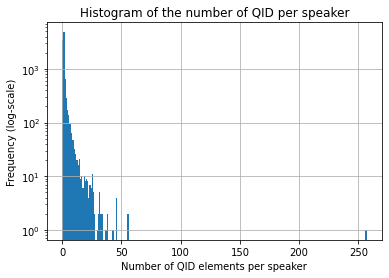

In [ ]:
# Check QID list's length of every loaded quotes 
length_qids = np.zeros(len(df_quotes))
for idx, qids in enumerate(df_quotes["qids"].values):
  length_qids[idx] = len(qids)
# Plot a histogram with log-scale on Y axis
plt.hist(length_qids, bins=int(np.max(length_qids)))
plt.yscale('log')
plt.grid('on')
plt.xlabel("Number of QID elements per speaker")
plt.ylabel("Frequency (log-scale)")
plt.title("Histogram of the number of QID per speaker")
#plt.xlim(0, 30) # Uncomment for focusing on a specific region 
plt.show()

In [ ]:
# Display the frequency using a dataframe instead of a histogram
val, freq = np.unique(length_qids, return_counts=True)
df_QID_freq = pd.DataFrame(data={"Nb. of QID":val, "Frequency":freq})
df_QID_freq.head(5)

,Nb. of QID,Frequency
0,0.0,3425
1,1.0,4832
2,2.0,663
3,3.0,285
4,4.0,170


## C) Data extraction

After checking the caveats of the database, in this section we will start extracting meaningful data for our analysis.

 ### 1) Generation of csvs

For simpler processing, we decide to first extract the data for each news outlet that we will analyse and store it in separate files, such that we don't need to parse the entire huge dataset every time. For each news outlet, we create one csv file containing the data for that news outlet per year, so six csv files per news outlet in total.

*Note: we choose to work with csvs instead of jsons because they are much easier to generate during the extraction of the data, since we process the data in chunks. CSVs allow to simply append the data at the end of the document, while appending to json files is much more complicated.*

During the generation of these files, we also generate some data that will be useful to us during the analysis part. Each quote will therefore have the following entries: `quoteID`, `quotation`, `speaker`, `qids`, `date`, `numOccurences`, `probas`, `quote_length`, `negative_sent`, `neutral_sent`, `positive_sent`, `compound`.

**Meaning of the variables defined above:**
 - `quoteID`: ID of the quote in the original *Quotebank* dataset 
 - `quotation`: The quotation 
 - `speaker`: Name of the most likely speaker determined by *Quobert* 
 - `qids`: Set of QIDs of the probable speakers 
 - `date`: Date of the quote
 - `numOccurences`: Number of times the same quote was cited in different news outlet 
 - `probas`: Probability of the quote being cited by the given speakers
 - `quote_length`: Quote length in words based on tokenization by `word_tokenize` from nltk library 
 - The next four variables were determined using `SentimentIntensityAnalyzer` from nltk library. Only the `compound` variable was kept for the analysis. 
    - `negative_sent`
    - `neutral_sent`
    - `positive_sent`
    - `compound`: The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

**How did we set the additional information per news outlets?**
- `Factual_reporting` Was determined from _https://mediabiasfactcheck.com_  ranges from:
    - Very low
    - Low 
    - Mixed
    - Mostly factual
    - High
    - Very high 
- `Political_leaning` Was determined from _https://mediabiasfactcheck.com_  ranges from:
    - Extreme
    - Left
    - Left-center
    - Neutral
    - Right-center
    - Right
    - Extreme
- `Nationality` We determined the nationality based on the domain extension and where their head-quarter is. 
- `Content_creator` Whether the website reports news from others news outlets or create their own content. For instance _msn.com_, _yahoo_ and _einnews.com_ mainly reports news from other websites. 
- `Traffic` Was determined from _https://mediabiasfactcheck.com_, in the end we did not use that variable. It ranges from:
    - Low
    - Medium
    - High 

First, we create functions that we will use to process the data from quotebank and generate additional data.

In [ ]:
PUNCTUATION = set(string.punctuation)
SIA = SentimentIntensityAnalyzer()

def remove_punctuation(l):
    return [w for w in l if w not in PUNCTUATION]

def sentiment_analysis(q):
    scores = SIA.polarity_scores(q)
    return scores["neg"], scores["neu"], scores["pos"], scores["compound"]

def perform_analyses(q):
    # Compute length of quotes
    tokens = word_tokenize(q)
    quote_length = len(remove_punctuation(tokens))  # Count number of words in the quote

    # Determine sentiment
    scores = sentiment_analysis(q)
    negative_sent, neutral_sent, positive_sent, compound = sentiment_analysis(q)  # Apply sentiment analyzer of nltk to obtain sentiment scores

    return quote_length, negative_sent, neutral_sent, positive_sent, compound

def get_target_doms(urls, domains):
    domains_set = {get_fld(url) for url in urls}
    return domains.intersection(domains_set)

Next, we generate the csvs for each selected news outlet for each year. 

We want to minimize the runtime, so we make sure to parse the whole dataset only once and directly extract, process and write the data we want. We identify the quotes cited by our target news outlets, generate the additional data we want for them and write the data of each quote to the files of each outlet that quoted it. Additionally, since we run the code on colab, there is the risk that the code might stop running after a given duration of inactivity. Therefore, we keep track of the processing advancement using a log file that is able to recover the state of the code before it stopped running. The log file will never cause us to miss out on any data, but it might still allow for some quotes to be written twice to the same file. Therefore, we will have to drop duplicates when loading the csv files during later analyses (as is anyway the best practice when we do not use our data for machine learning, which we do not in our project).

In [ ]:
def generate_csvs(domains, year, chunksize=10000, iter_max=None, use_log=False):
    '''
    Generates a csv per news outlet for given year
    '''

    # Path to quotebank file
    path_to_file = drive + 'Quotebank/quotes-'+ str(year) + '.json.bz2'
    df_chunks = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize, encoding="utf-8")

    path_new_csvs = drive + 'News_outlet_csvs/' + str(year) + "/"

    if not os.path.exists(path_new_csvs):  # Create new folders if they don't already exist
        os.makedirs(path_new_csvs)

    iterations_counter = 0
    if use_log:
        log_file = path_new_csvs + str(year) + "log.txt"
        if os.path.isfile(log_file):  # If log file exists
            with open(log_file, "r") as f:
                lines = f.readlines()
                iterations_counter_log = int(lines[-1])  # Read last log entry
                f.close()
        else:
            iterations_counter_log = 0

    header = "quoteID,quotation,speaker,qids,date,numOccurences,probas,quote_length,negative_sent,neutral_sent,positive_sent,compound\n"  # Header
    for dom in domains:
        csv_file = path_new_csvs + str(year) + "_" + dom +".csv"  # Csv file name
        if use_log:
            if not os.path.isfile(csv_file) or iterations_counter_log == 0:
                with open(csv_file, "w") as f:  # create new files with just the header if they don't yet exist or if we restart the process
                    f.write(header)
        else:
            if os.path.isfile(csv_file):  # If we don't use the log file to recover previous state, delete any existing csv_file and replace them with files containing just a header to avoid corrupted states
                os.remove(csv_file)
            with open(csv_file, "w") as f:
                f.write(header)

    for chunk in df_chunks:

        if use_log:
            if iterations_counter < iterations_counter_log:  # skip chunks until we have reached the last logged state
                if iterations_counter % 10 == 0:
                    print("Skipped chunk", iterations_counter)
                iterations_counter += 1
                continue

        if iter_max is not None and iterations_counter == iter_max:  # For debugging purposes
            break

        if iterations_counter % 10 == 0:  # Printing status, feedback for us when running
            print("Processing chunk", iterations_counter, "of year", year)
        
        chunk["target_doms"] = chunk.urls.apply(lambda x: get_target_doms(x, domains))  # Find quotes coming from our target domains
        chunk = chunk[chunk.target_doms != set()]  # Drop entries where the quote doesn't appear in any of our target domains
        chunk.drop(["urls", "phase"], axis=1, inplace=True)  # drop columns we don't need
        chunk["quote_length"], chunk["negative_sent"], chunk["neutral_sent"], chunk["positive_sent"], chunk["compound"] = zip(*chunk.quotation.map(perform_analyses))
        
        for dom in domains:  # For each target domain
            is_in_target_doms = chunk.target_doms.apply(lambda x: dom in x)  # Flag entries of quotes cited by dom
            data = chunk.where(is_in_target_doms)  # Select flagged entries
            data.dropna(inplace=True)  # Drop other entries
            data.drop(["target_doms"], axis=1, inplace=True)  # Drop column we don't need
            
            # Append data to corresponding file
            csv_file = path_new_csvs + str(year) + "_" + dom +".csv"
            data.to_csv(csv_file, mode='a', header=False, index=False)
        
        iterations_counter += 1

        # Write to log file to recover previous state in case colab stops running
        if use_log:
            with open(log_file, "a") as f:
                f.write(str(iterations_counter) + "\n")
                f.close()



We retrive the domains we selected for our analysis form the csv file generated during data exploration.

In [ ]:
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)

And we generate the csvs for each news outlet for each year.

In [ ]:
years = range(2015, 2021)
chunksize = 10000
#for year in years:  # Avoid re-running by mistake when running the notebook
#    generate_csvs(set(all_selected_doms.domain), year, chunksize=chunksize, use_log=True)  # commented such that we don't run it again when we run the entire notebook

In [ ]:
def load_csv_to_df(year, domain, folder="News_outlet_csvs"):
    '''Load csv of given year and domain to dataframe'''
    path = os.path.join(drive, folder, str(year), str(year) + "_" + domain + ".csv")
    outlet_df = pd.read_csv(path, encoding="utf-8")
    return outlet_df

### 2) Gathering the most cited speakers
Method: 
  - We will start by filtering the outlets that are based in the US, have a political leaning and are content creator. 
  - Then we will count the occurence of each speaker based on the *QID* per outlet per year. 
  - From this we will gather a top 15 of political of democrats and republicans speakers across all years and outlets (Section D).

To prepare the data for our analysis, we first need to load it into dataframes and convert columns to the right types.

In [ ]:
# Load the domains' name
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)
# The mask for selecting the correct outlets
mask = (all_selected_doms["Nationality"]=='US') & (all_selected_doms["Content_creator"]>0) & (all_selected_doms["Political_leaning"].notnull())
political_US_outlets = all_selected_doms[mask]
political_US_outlets

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
7,wtop.com,1,0,US,0.0,1,NaN,5.0
13,chicagotribune.com,0,1,US,1.0,1,High,5.0
14,sfgate.com,1,1,US,-1.0,1,High,5.0
16,upi.com,1,1,US,0.0,1,Medium,5.0
17,chron.com,1,0,US,-1.0,1,NaN,5.0
19,cnn.com,1,1,US,-2.0,1,High,3.0
27,nytimes.com,0,1,US,-1.0,1,High,5.0
28,thehill.com,1,0,US,0.0,1,High,4.0


In [ ]:
# Define the years 
list_years = [2015, 2016, 2017, 2018, 2019, 2020]
# Define the domain names
list_domains = political_US_outlets["domain"].values

In [ ]:
# Dictionnary that stores in each year a series with the count for each speaker
dict_cumulative_counts_1 = {}
for year in list_years:
  # To store the values per year
  cumulative_count = pd.Series([], dtype=float)
  for domain in list_domains:
    df_outlet = load_csv_to_df(year, domain)
    # Use value_count form pandas to count each set of QIDS occurence and use pd.DataFrame.add to sum on the corresponding set of QIDS, if set does not exist, it is added 
    cumulative_count = cumulative_count.add(df_outlet["qids"].value_counts(), fill_value=0)
  dict_cumulative_counts_1[year]=cumulative_count
  print("Done for year: " + str(year))

Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
# Export the results to CSV files
for year in list_years:
  df_year = dict_cumulative_counts_1[year]
  path = drive+"/Domains_count/"+str(year)+'_dict_counts_speakers.txt'
  df_year.to_csv(path, header=False, index=True) 

### 3) Get quote's length and compound sentiment distribution

Will be used to create simple histograms of quotes' length and compound's sentiment. The compound value will be rounded to a tenth, such that the histogram bins' width will be a tenth. 

In [ ]:
# Dictionary to store results per year 
dict_quote_len_year = {}
dict_quote_compound_year = {}
# Results all years
quote_len_all_year = pd.Series([], dtype=float)
quote_compound_all_year = pd.Series([], dtype=float)
# Will be used to count the occurence of quote length 
list_domains_extended = pd.read_csv(drive+"selected_domains.csv")["domain"]
list_years = [2015,2016,2017,2018,2019,2020]

for year in list_years:
  # To store the values per year
  cumulative_count_len = pd.Series([], dtype=float)
  cumulative_count_compound = pd.Series([], dtype=float)
  for domain in list_domains_extended:
    df_outlet = load_csv_to_df(year, domain)
    # Round the compound value to a tenth
    df_outlet["compound"] = df_outlet["compound"].round(decimals = 1)
    # Use value_count from pandas to count occurence of quote length and use pd.DataFrame.add
    cumulative_count_len = cumulative_count_len.add(df_outlet["quote_length"].value_counts(), fill_value=0)
    cumulative_count_compound = cumulative_count_compound.add(df_outlet["compound"].value_counts(), fill_value=0)
  
  # Store the results in the dict and aggregate
  dict_quote_len_year[year]=cumulative_count_len
  quote_len_all_year = quote_len_all_year.add(cumulative_count_len, fill_value=0)
  # Same for compound 
  dict_quote_compound_year[year]=cumulative_count_compound
  quote_compound_all_year = quote_compound_all_year.add(cumulative_count_compound, fill_value=0)
  print("Done for year: " + str(year))

# Convert the series to a dataframe 
quote_len_all_year = quote_len_all_year.reset_index()
quote_len_all_year.columns = ["length", "occurence"]
quote_len_all_year["length"] = quote_len_all_year["length"].astype(int)
# Same for compound
quote_compound_all_year = quote_compound_all_year.reset_index()
quote_compound_all_year.columns = ["compound", "occurence"]

Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
# Export the results to CSV files
for year in list_years:
  # Quote's length
  df_year_len = dict_quote_len_year[year]
  path = drive+"/Distribution_plot/"+str(year)+'_counts_quote_length.csv'
  df_year_len.to_csv(path, header=True, index=True)
  # Quote's compound sentiment
  df_year_com = dict_quote_compound_year[year]
  path = drive+"/Distribution_plot/"+str(year)+'_counts_quote_compound.csv'
  df_year_com.to_csv(path, header=True, index=True)
# Export for results across all years
path = drive+"/Distribution_plot/"+'all_years_counts_quote_length.csv'
quote_len_all_year.to_csv(path, header=True, index=True)
path = drive+"/Distribution_plot/"+'_all_years_counts_quote_compound.csv'
quote_compound_all_year.to_csv(path, header=True, index=True)

## D) Data preparation

After extraction of the relevant outlets and preprocessing of some values, here were prepare the data for the analysis: such as information about the speakers, stats about quotes' length, polarity, speaker political leaning, news outlet leaning etc. 

### 0) Extract polarity and quote from Donald Trump (for the introduction)

In [ ]:
QID_Trump_1 = "['Q22686']"
QID_Trump_2 = "['Q22686', 'Q27947481']"
test_df = load_csv_to_df(2015, "latimes.com")
Trump_count_1 = test_df.groupby("qids").size().loc[QID_Trump_1]
Trump_count_1

numpy.int64

In [ ]:
QID_Trump_1 = "['Q22686']"
QID_Trump_2 = "['Q22686', 'Q27947481']"
list_QIDs_Trump = [QID_Trump_1, QID_Trump_2]

# Intermediate variables 
quote_length_left = []
quote_length_right = []
compound_left = []
compound_right = []
occurence_left = []
occurence_right = []

for year in list_years:
  # Analyse Trump in the left leaning medias
  list_domains_left = political_US_outlets[political_US_outlets["Political_leaning"]<0]["domain"].values
  for outlet in list_domains_left:
    # Load the dataframe
    df_outlet = load_csv_to_df(year, outlet)
    
    if not df_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Get the list of qids present in the dataframe
      QIDS = qids_group_by["qids"].values
      # Iterate on them and only do the computation if Trump is present, it avoid computing on empty series
      for qid in QIDS:
        if qid in list_QIDs_Trump:
          # Compute the average quote length 
          quote_length_left.append(qids_group_by[qids_group_by['qids'] == qid]["quote_length"].values[0])
          # Compute the average compound sentiment
          compound_left.append((qids_group_by[qids_group_by['qids'] == qid]["compound"].values[0]))
          # Get the occurence of the speaker
          occurence_left.append(df_outlet.groupby("qids").size().loc[qid])
      
  # Analyse Trump in the right leaning medias
  list_domains_right = political_US_outlets[political_US_outlets["Political_leaning"]>0]["domain"].values
  for outlet in list_domains_right:
    
    # Load the dataframe
    df_outlet = load_csv_to_df(year, outlet)
    
    if not df_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Get the list of qids present in the dataframe
      QIDS = qids_group_by["qids"].values
      # Iterate on them and only do the computation if Trump is present, it avoid computing on empty series
      for qid in QIDS:
        if qid in list_QIDs_Trump:
          quote_length_right.append(qids_group_by[qids_group_by['qids'] == qid]["quote_length"].values[0])
          compound_right.append((qids_group_by[qids_group_by['qids'] == qid]["compound"].values[0]))
          occurence_right.append(df_outlet.groupby("qids").size().loc[qid])
  print("Done for year: "+str(year))

Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
# Compute stats for quote length 
len_left = DescrStatsW(quote_length_left, weights=occurence_left, ddof=0)
len_right = DescrStatsW(quote_length_right, weights=occurence_right, ddof=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=["Left leaning"], y=[np.round(len_left.mean,2)],
    error_y=dict(type='data', array=np.round([len_left.std_mean],4)),
    width=0.4
))

fig.add_trace(go.Bar(
    x=["Right leaning"], y=[np.round(len_right.mean,2)],
    error_y=dict(type='data', array=np.round([len_right.std_mean],4)),
    width=0.4
))

fig.update_layout(
    title="Trump quote length in left/right-leaning news outlet",
    title_x=0.5,
    xaxis_title="News outlet political orientation",
    yaxis_title="Mean quote length",
    hoverlabel=dict(namelength=0)
    )
fig.update_layout(showlegend=False)
fig.show()
fig.write_html("0_1.html")

In [ ]:
# Compute stats for compound sentiment
com_left = DescrStatsW(compound_left, weights=occurence_left, ddof=0)
com_right = DescrStatsW(compound_right, weights=occurence_right, ddof=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=["Left leaning"], y=[np.round(com_left.mean,2)],
    error_y=dict(type='data', array=np.round([com_left.std_mean],4)),
    width=0.4
))

fig.add_trace(go.Bar(
    x=["Right leaning"], y=[np.round(com_right.mean,2)],
    error_y=dict(type='data', array=np.round([com_right.std_mean],4)),
    width=0.4
))

fig.update_layout(
    title="Trump quote's positivity in left/right-leaning news outlet",
    title_x=0.5,
    xaxis_title="News outlet political orientation",
    yaxis_title="Positivity",
    hoverlabel=dict(namelength=0)
    )
#fig.update_layout(showlegend=False, yaxis= dict(visible = False))
fig.update_layout(showlegend=False)
fig.show()
fig.write_html("0_2.html")

### 1) Retrieve the most cited Democrat and Republican speakers

The first cell is simply a summary of the results we got in section C, here we load them again, in order to avoid running again section C. 

In [ ]:
# Load the domains' name
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)
# The mask for selecting the correct outlets
mask = (all_selected_doms["Nationality"]=='US') & (all_selected_doms["Content_creator"]>0) & (all_selected_doms["Political_leaning"].notnull())
political_US_outlets = all_selected_doms[mask]

# Define the years 
list_years = [2015, 2016, 2017, 2018, 2019, 2020]
# Define the domain names
list_domains = political_US_outlets["domain"].values

# Load cumulative speakers counts per year 
dict_cumulative_counts = {}
for year in list_years:
  path = drive+"/Domains_count/"+str(year)+'_dict_counts_speakers.txt'
  dict_cumulative_counts[year] = pd.read_csv(path, header = None, index_col = 0, squeeze = True)

#### Results across all years per **sets** of QIDS 

In [ ]:
# Count the most cited speakers across all years and news outlet  
cumulative_count_all = pd.Series([], dtype=float)
for year in list_years:
  year_series = dict_cumulative_counts[year]
  cumulative_count_all = cumulative_count_all.add(year_series, fill_value=0)
cumulative_count_all.index.name = 'idx'

In [ ]:
max_speakers = 75
# Gather the top 75 speakers and reset the index as column 
top_speakers = cumulative_count_all.sort_values(ascending=False).head(max_speakers).reset_index()
# Remove the first element because it corresponds to speaker having no wikidata page
top_speakers.drop(index=top_speakers.index[0], axis=0, inplace=True)
# Rename columns 
top_speakers.columns = ['QIDS', 'count']
# Reconvert the list (that are strings) to actual list using ast library
top_speakers["QIDS"] = top_speakers["QIDS"].apply(lambda x: (literal_eval(x)))

Here we had to decide how to solve the problem of speakers having more than one QID. We chose to use the first QID provided to retrieve the name and political party. As we only take a limited amount of speakers, we will manually assess whether the speaker has been assigned to the correct political party. 

In [ ]:
# Create a column named "name"
# Retrieve the name using the wikidata function described above 
top_speakers["name"] = top_speakers.apply(lambda x: retrieve_wikidata_properties(x.QIDS[0]).iloc[0].label, axis=1)
# Same idea but for the political party, we use the first QID to retrieve the party, not a correct heuristic though 
top_speakers["party"] = top_speakers.apply(lambda x: human_readable_properties(retrieve_wikidata_properties(x.QIDS[0]), 'party'), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


In [ ]:
top_speakers.head()

,QIDS,count,name,party
1,[Q22686],285454.0,Donald Trump,"[Republican Party, Independence Party of Ameri..."
2,"[Q22686, Q27947481]",89949.0,Donald Trump,"[Republican Party, Independence Party of Ameri..."
3,[Q76],53341.0,Barack Obama,[Democratic Party]
4,[Q6294],38951.0,Hillary Clinton,"[Democratic Party, Republican Party]"
5,[Q359442],28220.0,Bernie Sanders,"[Liberty Union Party, Democratic Party, indepe..."


We save the apolitical (at least the speakers that do not belong to any political party) in a new dataframe in case we later want to run analysis on them.

In [ ]:
top_speakers["No_party"] = top_speakers["party"].apply(lambda x: x is None)
apo_speakers = top_speakers[top_speakers["No_party"]==True]

For our analysis we only want to look at the speakers belonging to the Republican or Democratic party. Therefore, we drop all the speakers that are not part of one of them.

In [ ]:
top_speakers.dropna(subset=["party"], inplace = True)

In order to separate Republicans and Democrats we one-hot encode the belonging to both parties in two new columns.

In [ ]:
top_speakers["Democrat"] = top_speakers["party"].apply(lambda x: "Democratic Party" in x)
top_speakers["Republican"] = top_speakers["party"].apply(lambda x: "Republican Party" in x)

We check if some speakers belong to both parties.

In [ ]:
top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]]

,QIDS,count,name,party,No_party,Democrat,Republican
1,[Q22686],285454.0,Donald Trump,"[Republican Party, Independence Party of Ameri...",False,True,True
2,"[Q22686, Q27947481]",89949.0,Donald Trump,"[Republican Party, Independence Party of Ameri...",False,True,True
4,[Q6294],38951.0,Hillary Clinton,"[Democratic Party, Republican Party]",False,True,True
17,[Q7747],15565.0,Vladimir Putin,"[Communist Party of the Soviet Union, Our Home...",False,False,False
21,[Q43723],14061.0,Benjamin Netanyahu,[Likud],False,False,False
27,[Q3052772],11909.0,Emmanuel Macron,"[La République En Marche, Socialist Party, ind...",False,False,False
30,[Q567],10871.0,Angela Merkel,"[Christian Democratic Union, Democratic Awaken...",False,False,False
38,[Q39259],9740.0,Recep Tayyip Erdoğan,"[National Salvation Party, Welfare Party, Virt...",False,False,False
53,[Q816459],7916.0,Ben Carson,"[Republican Party, Democratic Party, independe...",False,True,True
54,[Q264766],7662.0,Theresa May,[Conservative Party],False,False,False


We know for sure that Donald Trump actually belonged to the Republican Party during the time of the analysis whereas Hillary Clinton and Ben Carson do belong to the Democrat party. Thus, we manually correct their affiliation.

In [ ]:
top_speakers.at[1,"Democrat"] = False #Speakers 1 and 2 both correspond to Donald Trump (2 sets of QIDs)
top_speakers.at[2,"Democrat"] = False
top_speakers.at[4,"Republican"] = False #Speaker 4 corresponds to Hillary Clinton
top_speakers.at[53,"Republican"] = False # Speaker 53 correponds to Ben Carson

Now the only speakers that still have the same values in columns `Democrat` and `Republican`are the one that do not belong to any party so discard them.

In [ ]:
top_speakers.drop(top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]].index,inplace=True)

In [ ]:
top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]]

,QIDS,count,name,party,No_party,Democrat,Republican


Now we can create the two list containing the top 15 speakers of both parties that we will use for the rest of our analysis.

In [ ]:
rep_speakers = top_speakers[top_speakers["Republican"]==True].iloc[0:15]
dem_speakers = top_speakers[top_speakers["Democrat"]==True].iloc[0:15]

We will need the QIDs of all these speakers to retrieve the data of interest so we already store them in a simple list.

In [ ]:
# Get the list of the democrat speakers QID as string
dem_speakers_QIDS = []
for list_QIDS in dem_speakers.QIDS: 
  dem_speakers_QIDS.append((str(list_QIDS))) 

# Get the list of the republican speakers QID as string
rep_speakers_QIDS = []
for list_QIDS in rep_speakers.QIDS: 
  rep_speakers_QIDS.append((str(list_QIDS))) 

# Get the list of the apolitical speakers QID as string
apo_speakers_QIDS = []
for list_QIDS in apo_speakers.QIDS: 
  apo_speakers_QIDS.append((str(list_QIDS))) 

In [ ]:
# Send the results to CSV 
dem_speakers[["count", "name"]].to_csv(drive+"top_dem_speakers_count.csv", index=False, header=False)
rep_speakers[["count", "name"]].to_csv(drive+"top_rep_speakers_count.csv", index=False, header=False)
apo_speakers[["count", "name"]].to_csv(drive+"top_apo_speakers_count.csv", index=False, header=False)


### 2) Computations on the data needed for part 1) of the Analysis

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean = []
length_error = []
compound_mean = [] #Mean of the polarity score
compound_error = []

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  length_mean_list = []
  compound_mean_list = []
  quotes_weight_list = []

  for row in all_selected_doms.iterrows() :
    # Select domains in top 200 every year, that are content creator and from the US
    if (row[1]["Year_by_year"] == 1) and (row[1]["Content_creator"] == 1) and (row[1]["Nationality"] == "US"):
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      quotes_weight_list.append(df_year_outlet.shape[0]) # Save the number of quotes in each outlet
      length_mean_list.append(df_year_outlet["quote_length"].mean()) # Compute the mean length of each outlet
      compound_mean_list.append(df_year_outlet["compound"].mean()) # Compute the mean polarity score of each outlet

  # To compute the weighted mean and standard error of the mean we use the function
  # DescrStatsW from the statsmodels.stats library 

  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length = DescrStatsW(length_mean_list, weights=quotes_weight_list, ddof=0)
  length_mean.append(weighted_stats_length.mean)
  length_error.append(weighted_stats_length.std_mean)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound = DescrStatsW(compound_mean_list, weights=quotes_weight_list, ddof=0) # We use this class from statsmodel.stats for the computation
  compound_mean.append(weighted_stats_compound.mean)
  compound_error.append(weighted_stats_compound.std_mean)

In [ ]:
# Computes the mean for each year and each news outlet (either quote length, or polarity)
def get_mean_of_col_for_each_outlet_per_year(col, list_of_outlets):

    years = range(2015, 2021)
    all_means = dict()
    for outlet in list_of_outlets:  # max 54
        for year in years:  # 6
            df = load_csv_to_df(year,outlet)
            mean_of_col = df[col].mean()
            keys = all_means.keys()
            if outlet in keys:
                all_means[outlet][year] = mean_of_col
            else:
                new_dict = dict()
                new_dict[year] = mean_of_col
                all_means[outlet] = new_dict

    return pd.DataFrame(all_means)

In [ ]:
df_means_length = get_mean_of_col_for_each_outlet_per_year("quote_length", list_domains)
df_means_compound = get_mean_of_col_for_each_outlet_per_year("compound", list_domains)

The cell below is used to plot the second figure, which is the evolution of quote mean length for news outlets of different political orientations. 

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean_left, length_mean_right, length_mean_neutral = [],[],[]
length_error_left, length_error_right, length_error_neutral = [],[],[]
compound_mean_left, compound_mean_right, compound_mean_neutral = [],[],[]
compound_error_left, compound_error_right, compound_error_neutral = [],[],[]

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  quotes_weight_list_left, quotes_weight_list_right, quotes_weight_list_neutral = [],[],[]
  length_mean_list_left, length_mean_list_right, length_mean_list_neutral = [],[],[]
  compound_mean_list_left, compound_mean_list_right, compound_mean_list_neutral = [],[],[]

  for row in all_selected_doms.dropna(subset=["Political_leaning"]).iterrows() :
    if (row[1]["Year_by_year"] == 1) & (row[1]["Content_creator"] == 1) & (row[1]["Nationality"] == "US") :
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      
      #The political_leaning variable has values between -3 (extreme left) and +3 (extreme right), 0 being neutral
      if row[1]["Political_leaning"] < 0 :
        quotes_weight_list_left.append(df_year_outlet.shape[0])
        length_mean_list_left.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_left.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] > 0 :
        quotes_weight_list_right.append(df_year_outlet.shape[0])
        length_mean_list_right.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_right.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] == 0 :
        quotes_weight_list_neutral.append(df_year_outlet.shape[0])
        length_mean_list_neutral.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_neutral.append(df_year_outlet["compound"].mean())
        
  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length_left = DescrStatsW(length_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  length_mean_left.append(weighted_stats_length_left.mean)
  length_error_left.append(weighted_stats_length_left.std_mean)
  
  weighted_stats_length_right = DescrStatsW(length_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  length_mean_right.append(weighted_stats_length_right.mean)
  length_error_right.append(weighted_stats_length_right.std_mean)

  weighted_stats_length_neutral = DescrStatsW(length_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  length_mean_neutral.append(weighted_stats_length_neutral.mean)
  length_error_neutral.append(weighted_stats_length_neutral.std_mean)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound_left = DescrStatsW(compound_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  compound_mean_left.append(weighted_stats_compound_left.mean)
  compound_error_left.append(weighted_stats_compound_left.std_mean)
  
  weighted_stats_compound_right = DescrStatsW(compound_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  compound_mean_right.append(weighted_stats_compound_right.mean)
  compound_error_right.append(weighted_stats_compound_right.std_mean)

  weighted_stats_compound_neutral = DescrStatsW(compound_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  compound_mean_neutral.append(weighted_stats_compound_neutral.mean)
  compound_error_neutral.append(weighted_stats_compound_neutral.std_mean)


### 3) Computations on the data needed for part 2) of the Analysis

See below the description of the variables we will store in the columns. The rows will represent the years. 
- `L` for outlet having a left political bias
  - `N` for neutral 
  - `R` for right
- `Pol` for the average polarity score 
- `Pol_err` for average polarity error 
- `Len` for the average quote's length
- `Len_err` for average quote's length error
- `Count` for the occurence of democrats/republicans speaker in the given outlet having political leaning L/N/R 

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
# Define the dataframes storing the reslts 
col_name = ['L_Pol', 'L_Pol_err', 'L_Len', 'L_Len_err', 'L_Count', 'N_Pol', 'N_Pol_err', 'N_Len', 'N_Len_err', 'N_Count', 'R_Pol', 'R_Pol_err', 'R_Len', 'R_Len_err', 'R_Count']
# The democract df
df_speakers_stats_dem = pd.DataFrame(columns=col_name, index=time_scale) #Stats of democrat speakers depending on the political leaning of the news outlets
# The republican df 
df_speakers_stats_rep = pd.DataFrame(columns=col_name, index=time_scale) #Stats of Republican speakers depending on the political leaning of the news outlets


for year in time_scale :

  
  # 1) Start by retrieving the data


  # Temporary variables to stock intermediates means and weights for republican speakers
  quotes_count_list_left_rep, quotes_count_list_right_rep, quotes_count_list_neutral_rep = [],[],[]
  length_mean_list_left_rep, length_mean_list_right_rep, length_mean_list_neutral_rep = [],[],[]
  compound_mean_list_left_rep, compound_mean_list_right_rep, compound_mean_list_neutral_rep = [],[],[]
  # Temporary variables to stock intermediates means and weights for democrat speakers
  quotes_count_list_left_dem, quotes_count_list_right_dem, quotes_count_list_neutral_dem = [],[],[]
  length_mean_list_left_dem, length_mean_list_right_dem, length_mean_list_neutral_dem = [],[],[]
  compound_mean_list_left_dem, compound_mean_list_right_dem, compound_mean_list_neutral_dem = [],[],[]

  for row in political_US_outlets.iterrows() :
    df_year_outlet = load_csv_to_df(year,row[1]["domain"]).dropna(subset=["qids"])
    # Make sure that we have a not empty dataframe 
    if not df_year_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_year_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Count the number of quotes per QIDS
      qids_count = df_year_outlet.groupby("qids").size()
      
      # Iterate on the QIDS/speakers of the given outlet and check whether they belong to democrat or republican 
      for qid in qids_group_by["qids"].values:
        # Check if the speaker is a DEMOCRAT
        if qid in dem_speakers_QIDS : 
          # Check whether the outlet has a Left political bias 
          if row[1]["Political_leaning"] < 0:
            quotes_count_list_left_dem.append(qids_count.loc[qid])
            length_mean_list_left_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_left_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a Neutral political bias 
          if row[1]["Political_leaning"] > 0:
            quotes_count_list_right_dem.append(qids_count.loc[qid])
            length_mean_list_right_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_right_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a Right political bias 
          if row[1]["Political_leaning"] == 0:
            quotes_count_list_neutral_dem.append(qids_count.loc[qid])
            length_mean_list_neutral_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_neutral_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
         # Check if the speaker is REPUBLICAN
        if qid in rep_speakers_QIDS :

          if row[1]["Political_leaning"] < 0:
            quotes_count_list_left_rep.append(qids_count.loc[qid])
            length_mean_list_left_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_left_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Political_leaning"] > 0:
            quotes_count_list_right_rep.append(qids_count.loc[qid])
            length_mean_list_right_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_right_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Political_leaning"] == 0:
            quotes_count_list_neutral_rep.append(qids_count.loc[qid])
            length_mean_list_neutral_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_neutral_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          
    
    
    
  # 2) After retrieving the data, compute the STATISTICS
  



  #################################################### FOR DEMOCRATS #########################################################  

  yearly_stats_dem = [] # list to push in the final dataframe

  #Left outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_left_dem = DescrStatsW(compound_mean_list_left_dem, weights=quotes_count_list_left_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_left_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_left_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_left_dem = DescrStatsW(length_mean_list_left_dem, weights=quotes_count_list_left_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_left_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_left_dem.std_mean)

  #Count for left :
  yearly_stats_dem.append(np.array(quotes_count_list_left_dem).sum())

  #Neutral outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_neutral_dem = DescrStatsW(compound_mean_list_neutral_dem, weights=quotes_count_list_neutral_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_neutral_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_neutral_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_neutral_dem = DescrStatsW(length_mean_list_neutral_dem, weights=quotes_count_list_neutral_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_neutral_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_neutral_dem.std_mean)

  #Count for Neutral :
  yearly_stats_dem.append(np.array(quotes_count_list_neutral_dem).sum())

  #Right outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_right_dem = DescrStatsW(compound_mean_list_right_dem, weights=quotes_count_list_right_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_right_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_right_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_right_dem = DescrStatsW(length_mean_list_right_dem, weights=quotes_count_list_right_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_right_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_right_dem.std_mean)

  #Count for Right :
  yearly_stats_dem.append(np.array(quotes_count_list_right_dem).sum())

  # Push the results into the df 
  df_speakers_stats_dem.loc[year] = yearly_stats_dem 

  #################################################### FOR REPUBLICAN #########################################################  

  yearly_stats_rep = [] # list to push in the final dataframe

  #Left outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_left_rep = DescrStatsW(compound_mean_list_left_rep, weights=quotes_count_list_left_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_left_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_left_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_left_rep = DescrStatsW(length_mean_list_left_rep, weights=quotes_count_list_left_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_left_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_left_rep.std_mean)

  #Count for left :
  yearly_stats_rep.append(np.array(quotes_count_list_left_rep).sum())

  #Neutral outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_neutral_rep = DescrStatsW(compound_mean_list_neutral_rep, weights=quotes_count_list_neutral_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_neutral_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_neutral_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_neutral_rep = DescrStatsW(length_mean_list_neutral_rep, weights=quotes_count_list_neutral_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_neutral_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_neutral_rep.std_mean)

  #Count for neutral :
  yearly_stats_rep.append(np.array(quotes_count_list_neutral_rep).sum())

  #Right outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_right_rep = DescrStatsW(compound_mean_list_right_rep, weights=quotes_count_list_right_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_right_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_right_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_right_rep = DescrStatsW(length_mean_list_right_rep, weights=quotes_count_list_right_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_right_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_right_rep.std_mean)

  #Count for right :
  yearly_stats_rep.append(np.array(quotes_count_list_right_rep).sum())

  # Push the results into the df 
  df_speakers_stats_rep.loc[year] = yearly_stats_rep

  # To keep track of the progress 
  print("Done for year: " + str(year)) 

Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
df_speakers_stats_dem.head(6)

,L_Pol,L_Pol_err,L_Len,L_Len_err,L_Count,N_Pol,N_Pol_err,N_Len,N_Len_err,N_Count,R_Pol,R_Pol_err,R_Len,R_Len_err,R_Count
2015,0.0771815,0.000265631,19.9727,0.0123081,37877,0.103781,0.000531764,20.4276,0.0214962,10461,0.0712252,0.000368541,23.1722,0.0315093,18497
2016,0.0888006,0.00028586,19.5664,0.0125095,30474,0.104512,0.000852697,21.6488,0.0382898,5905,0.0836185,0.000351611,20.9257,0.015071,17582
2017,0.0625622,0.00047482,19.6372,0.0211678,18034,0.0504796,0.00071748,21.4499,0.0286184,5853,0.0524413,0.000634487,21.2274,0.0273854,11005
2018,0.0726006,0.000552276,19.7297,0.0251648,14293,0.0618534,0.000849529,21.939,0.038809,6014,0.0634342,0.000494719,21.8996,0.0269668,11262
2019,0.0636577,0.000276032,19.662,0.0168749,32291,0.0655277,0.000485359,21.9286,0.0297682,9970,0.0580618,0.00024684,22.2775,0.0170121,27005
2020,0.0642667,0.000602276,19.5252,0.0298069,12618,0.0649828,0.00115321,21.6443,0.0572883,3697,0.0497961,0.000571691,22.2083,0.035578,10160


Then we create two new dataframes (one for Democrats and one for Republicans) that will contain a weighted mean of each variable over all years

In [ ]:
df_speakers_stats_total_dem = pd.DataFrame(columns=col_name,index=["total"]) # Dataframe containing overall weighted mean for every political leaning and democrat speakers
df_speakers_stats_total_rep = pd.DataFrame(columns=col_name,index=["total"]) # Dataframe containing overall weighted mean for every political leaning and democrat speakers

Now that both dataframes are created, we compute the means and fill them

In [ ]:
# Computation for Democrat speakers
for pref in ["L_","N_","R_"]:
  variables = [pref+"Pol",pref+"Pol_err",pref+"Len",pref+"Len_err"]
  count = pref+"Count"
  for var in [0,2] :
       weighted_stats = DescrStatsW(df_speakers_stats_dem[variables[var]], weights=df_speakers_stats_dem[count], ddof=0)
       df_speakers_stats_total_dem.at['total',variables[var]] = weighted_stats.mean # computation of the mean
       df_speakers_stats_total_dem.at["total",variables[var+1]] = weighted_stats.std_mean # computation of the standard error of the mean
  df_speakers_stats_total_dem.at['total',count] = df_speakers_stats_dem[count].sum()

# Computation for Republicans speakers    
for pref in ["L_","N_","R_"]:
  variables = [pref+"Pol",pref+"Pol_err",pref+"Len",pref+"Len_err"]
  count = pref+"Count"
  for var in [0,2] :
       weighted_stats = DescrStatsW(df_speakers_stats_rep[variables[var]], weights=df_speakers_stats_rep[count], ddof=0)
       df_speakers_stats_total_rep.at["total",variables[var]] = weighted_stats.mean # computation of the mean
       df_speakers_stats_total_rep.at["total",variables[var+1]] = weighted_stats.std_mean # computation of the standard error of the mean
  df_speakers_stats_total_rep.at['total',count] = df_speakers_stats_rep[count].sum()
  

### 4) Computations on the data needed for part 3) of the Analysis

See below the description of the variables we will store in the columns. The rows will represent the years. 
- `Hi` for outlet having a High factual reporting
  - `Mo` for Mostly factual reporting
  - `Mi` for Mixed factual reportging
- `Pol` for the average polarity score 
- `Pol_err` for average polarity error 
- `Len` for the average quote's length
- `Len_err` for average quote's length error
- `Count` for the occurence of democrats/republicans speaker in the given outlet having factual reportgin Hi/Mo/Mi 

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
# Define the dataframes storing the reslts 
col_name_FR = ['Mi_Pol', 'Mi_Pol_err', 'Mi_Len', 'Mi_Len_err', 'Mi_Count', 'Mo_Pol', 'Mo_Pol_err', 'Mo_Len', 'Mo_Len_err', 'Mo_Count', 'Hi_Pol', 'Hi_Pol_err', 'Hi_Len', 'Hi_Len_err', 'Hi_Count']
# The democract df
df_speakers_stats_dem_FR = pd.DataFrame(columns=col_name_FR, index=time_scale) # Stats of democrat speakers depending on the Factual Report score of the news outlets
# The republican df 
df_speakers_stats_rep_FR = pd.DataFrame(columns=col_name_FR, index=time_scale) #Stats of Republican speakers depending on the Factual Report score of the news outlets


for year in time_scale :

  
  # 1) Start by retrieving the data


  # Temporary variables to stock intermediates means and weights for republican speakers
  quotes_count_list_Mi_rep, quotes_count_list_Hi_rep, quotes_count_list_Mo_rep = [],[],[]
  length_mean_list_Mi_rep, length_mean_list_Hi_rep, length_mean_list_Mo_rep = [],[],[]
  compound_mean_list_Mi_rep, compound_mean_list_Hi_rep, compound_mean_list_Mo_rep = [],[],[]
  # Temporary variables to stock intermediates means and weights for democrat speakers
  quotes_count_list_Mi_dem, quotes_count_list_Hi_dem, quotes_count_list_Mo_dem = [],[],[]
  length_mean_list_Mi_dem, length_mean_list_Hi_dem, length_mean_list_Mo_dem = [],[],[]
  compound_mean_list_Mi_dem, compound_mean_list_Hi_dem, compound_mean_list_Mo_dem = [],[],[]

  for row in political_US_outlets.iterrows() :
    df_year_outlet = load_csv_to_df(year,row[1]["domain"]).dropna(subset=["qids"])
    # Make sure that we have a not empty dataframe 
    if not df_year_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_year_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Count the number of quotes per QIDS
      qids_count = df_year_outlet.groupby("qids").size()
      
      # Iterate on the QIDS/speakers of the given outlet and check whether they belong to democrat or republican 
      for qid in qids_group_by["qids"].values:
        # Check if the speaker is a DEMOCRAT
        if qid in dem_speakers_QIDS : 
          # Check whether the outlet has a Mixed factual reporting
          if row[1]["Factual_reporting"] == 3:
            quotes_count_list_Mi_dem.append(qids_count.loc[qid])
            length_mean_list_Mi_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Mi_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a Mostly factual reporting 
          if row[1]["Factual_reporting"] == 4:
            quotes_count_list_Hi_dem.append(qids_count.loc[qid])
            length_mean_list_Hi_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Hi_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a High factual reporting 
          if row[1]["Factual_reporting"] == 5:
            quotes_count_list_Mo_dem.append(qids_count.loc[qid])
            length_mean_list_Mo_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Mo_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
         # Check if the speaker is REPUBLICAN
        if qid in rep_speakers_QIDS :

          if row[1]["Factual_reporting"] == 3:
            quotes_count_list_Mi_rep.append(qids_count.loc[qid])
            length_mean_list_Mi_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Mi_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Factual_reporting"] == 4:
            quotes_count_list_Hi_rep.append(qids_count.loc[qid])
            length_mean_list_Hi_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Hi_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Factual_reporting"] == 5:
            quotes_count_list_Mo_rep.append(qids_count.loc[qid])
            length_mean_list_Mo_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_Mo_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          
    
    
    
  # 2) After retrieving the data, compute the STATISTICS
  



  #################################################### FOR DEMOCRATS #########################################################  

  yearly_stats_dem_FR = [] # list to push in the final dataframe

  #Mixed F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Mi_dem = DescrStatsW(compound_mean_list_Mi_dem, weights=quotes_count_list_Mi_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_compound_Mi_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_compound_Mi_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Mi_dem = DescrStatsW(length_mean_list_Mi_dem, weights=quotes_count_list_Mi_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_length_Mi_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_length_Mi_dem.std_mean)

  #Count for Mixed F-R :
  yearly_stats_dem_FR.append(np.array(quotes_count_list_Mi_dem).sum())

  #Mostly F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Mo_dem = DescrStatsW(compound_mean_list_Mo_dem, weights=quotes_count_list_Mo_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_compound_Mo_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_compound_Mo_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Mo_dem = DescrStatsW(length_mean_list_Mo_dem, weights=quotes_count_list_Mo_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_length_Mo_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_length_Mo_dem.std_mean)

  #Count for Mostly F-R :
  yearly_stats_dem_FR.append(np.array(quotes_count_list_Mo_dem).sum())

  #High F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Hi_dem = DescrStatsW(compound_mean_list_Hi_dem, weights=quotes_count_list_Hi_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_compound_Hi_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_compound_Hi_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Hi_dem = DescrStatsW(length_mean_list_Hi_dem, weights=quotes_count_list_Hi_dem, ddof=0)
  yearly_stats_dem_FR.append(weighted_stats_length_Hi_dem.mean)
  yearly_stats_dem_FR.append(weighted_stats_length_Hi_dem.std_mean)

  #Count for High F-R :
  yearly_stats_dem_FR.append(np.array(quotes_count_list_Hi_dem).sum())

  # Push the results into the df 
  df_speakers_stats_dem_FR.loc[year] = yearly_stats_dem_FR 

  #################################################### FOR REPUBLICAN #########################################################  

  yearly_stats_rep_FR = [] # list to push in the final dataframe

  #Mixed F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Mi_rep = DescrStatsW(compound_mean_list_Mi_rep, weights=quotes_count_list_Mi_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_compound_Mi_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_compound_Mi_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Mi_rep = DescrStatsW(length_mean_list_Mi_rep, weights=quotes_count_list_Mi_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_length_Mi_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_length_Mi_rep.std_mean)

  #Count for Mixed F-R :
  yearly_stats_rep_FR.append(np.array(quotes_count_list_Mi_rep).sum())

  #Mostly F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Mo_rep = DescrStatsW(compound_mean_list_Mo_rep, weights=quotes_count_list_Mo_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_compound_Mo_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_compound_Mo_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Mo_rep = DescrStatsW(length_mean_list_Mo_rep, weights=quotes_count_list_Mo_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_length_Mo_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_length_Mo_rep.std_mean)

  #Count for Mostly F-R :
  yearly_stats_rep_FR.append(np.array(quotes_count_list_Mo_rep).sum())

  #High F-R outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_Hi_rep = DescrStatsW(compound_mean_list_Hi_rep, weights=quotes_count_list_Hi_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_compound_Hi_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_compound_Hi_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_Hi_rep = DescrStatsW(length_mean_list_Hi_rep, weights=quotes_count_list_Hi_rep, ddof=0)
  yearly_stats_rep_FR.append(weighted_stats_length_Hi_rep.mean)
  yearly_stats_rep_FR.append(weighted_stats_length_Hi_rep.std_mean)

  #Count for High F-R :
  yearly_stats_rep_FR.append(np.array(quotes_count_list_Hi_rep).sum())

  # Push the results into the df 
  df_speakers_stats_rep_FR.loc[year] = yearly_stats_rep_FR

  # To keep track of the progress 
  print("Done for year: " + str(year)) 


Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
df_speakers_stats_dem_FR.head(6)

,Mi_Pol,Mi_Pol_err,Mi_Len,Mi_Len_err,Mi_Count,Mo_Pol,Mo_Pol_err,Mo_Len,Mo_Len_err,Mo_Count,Hi_Pol,Hi_Pol_err,Hi_Len,Hi_Len_err,Hi_Count
2015,0.0723012,0.000317425,23.3242,0.0254302,21362,0.0796404,0.000325897,18.8352,0.0128262,30419,0.0903037,0.000415694,21.7629,0.010336,15054
2016,0.0871056,0.000341372,21.6114,0.0114391,19184,0.0888876,0.000337871,18.9696,0.014838,26407,0.0926098,0.000516868,21.0863,0.0141785,8370
2017,0.0539171,0.000567936,21.6034,0.0249857,11533,0.059722,0.000553209,18.8875,0.0207996,16154,0.0574941,0.000584805,22.0722,0.0193074,7205
2018,0.0689519,0.000508844,22.2841,0.0231573,12455,0.0693501,0.000571215,18.8999,0.0239008,13742,0.058127,0.000787046,22.9522,0.0268946,5372
2019,0.0602379,0.000231444,22.9232,0.0131302,31727,0.0636955,0.000298361,18.5773,0.0135184,31201,0.0596891,0.000421193,23.3859,0.0214751,6338
2020,0.0590225,0.000502338,22.9882,0.028254,11712,0.056716,0.000654717,18.4144,0.0248082,12587,0.0698214,0.00131289,23.4393,0.046793,2176


Then we create two new dataframes (one for Democrats and one for Republicans) that will contain a weighted mean of each variable over all years

In [ ]:
df_speakers_stats_total_dem_FR = pd.DataFrame(columns=col_name_FR,index=["total"]) # Dataframe containing overall weighted mean for every factual reporting and democrat speakers
df_speakers_stats_total_rep_FR = pd.DataFrame(columns=col_name_FR,index=["total"]) # Dataframe containing overall weighted mean for every factual reporting and democrat speakers

Now that both dataframes are created, we compute the means and fill them

In [ ]:
# Computation for Democrat speakers
for pref in ["Mi_","Mo_","Hi_"]:
  variables = [pref+"Pol",pref+"Pol_err",pref+"Len",pref+"Len_err"]
  count = pref+"Count"
  for var in [0,2] :
       weighted_stats = DescrStatsW(df_speakers_stats_dem_FR[variables[var]], weights=df_speakers_stats_dem_FR[count], ddof=0)
       df_speakers_stats_total_dem_FR.at['total',variables[var]] = weighted_stats.mean # Computation of the mean
       df_speakers_stats_total_dem_FR.at["total",variables[var+1]] = weighted_stats.std_mean # Computation of the standard error of the mean
  df_speakers_stats_total_dem_FR.at['total',count] = df_speakers_stats_dem_FR[count].sum()

# Computation for Republicans speakers    
for pref in ["Mi_","Mo_","Hi_"]:
  variables = [pref+"Pol",pref+"Pol_err",pref+"Len",pref+"Len_err"]
  count = pref+"Count"
  for var in [0,2] :
       weighted_stats = DescrStatsW(df_speakers_stats_rep_FR[variables[var]], weights=df_speakers_stats_rep_FR[count], ddof=0)
       df_speakers_stats_total_rep_FR.at["total",variables[var]] = weighted_stats.mean # Computation of the mean
       df_speakers_stats_total_rep_FR.at["total",variables[var+1]] = weighted_stats.std_mean # Computation of the standard error of the mean
  df_speakers_stats_total_rep_FR.at['total',count] = df_speakers_stats_rep_FR[count].sum()

For the last graph we want to compute the apolitical speakers mean polarity.

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean_apo = []
length_error_apo = 0
compound_mean_apo = [] #Mean of the polarity score
compound_error_apo = 0
quotes_weight_apo = []

for year in time_scale :
  for row in political_US_outlets.iterrows() :
    df_year_outlet = load_csv_to_df(year,row[1]["domain"]).dropna(subset=["qids"])
    # Make sure that we have a not empty dataframe 
    if not df_year_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_year_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Count the number of quotes per QIDS
      qids_count = df_year_outlet.groupby("qids").size()
      # Iterate on the QIDS/speakers of the given outlet and check whether they belong to democrat or republican 
      for qid in qids_group_by["qids"].values:
        # Check if the speaker is apolical
        if qid in apo_speakers_QIDS :
          quotes_weight_apo.append(qids_count.loc[qid])
          length_mean_apo.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
          compound_mean_apo.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

  print("Computation done for year : " + str(year))

# Computation of weighted mean and standard error of the mean for the length
weighted_stats_length = DescrStatsW(length_mean_apo, weights=quotes_weight_apo, ddof=0)
length_mean_apo = weighted_stats_length.mean
length_error_apo = weighted_stats_length.std_mean

# Computation of weighted mean and standard error of the mean for the polarity score
weighted_stats_compound = DescrStatsW(compound_mean_apo, weights=quotes_weight_apo, ddof=0) # We use this class from statsmodel.stats for the computation
compound_mean_apo = weighted_stats_compound.mean
compound_error_apo = weighted_stats_compound.std_mean

Computation done for year : 2015
Computation done for year : 2016
Computation done for year : 2017
Computation done for year : 2018
Computation done for year : 2019
Computation done for year : 2020


In [ ]:
political_US_outlets.head()

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
7,wtop.com,1,0,US,0.0,1,NaN,5.0
13,chicagotribune.com,0,1,US,1.0,1,High,5.0
14,sfgate.com,1,1,US,-1.0,1,High,5.0


Computation of data for the analysis of the correlation between the factual reporting and websites ratio of speakers from their own orientation and from the oposite orientation

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]

quotes_count_dem_list = []
quotes_count_rep_list = []

for outlet in political_US_outlets.iterrows():
  quotes_count_dem = 0
  quotes_count_rep = 0
  for year in time_scale:
    df_year_outlet = load_csv_to_df(year,outlet[1]["domain"])#.dropna(subset=["qids"])
    # Make sure that we have a not empty dataframe 
    if not df_year_outlet.empty:
      # Count the number of quotes per QIDS
      qids_count = df_year_outlet.groupby("qids").size()
      # Iterate on the QIDS/speakers of the given outlet and check whether they belong to democrat or republican 
      for qid in qids_count.index.values:
        # Check if the speaker is a Democrat
        if qid in dem_speakers_QIDS :
          quotes_count_dem += qids_count.loc[qid]
        # Check if the speaker is a Republican
        if qid in rep_speakers_QIDS :
          quotes_count_rep += qids_count.loc[qid]
  quotes_count_dem_list.append(quotes_count_dem)
  quotes_count_rep_list.append(quotes_count_rep)
  print("Computation done for news outlet : " + outlet[1]["domain"])
  
political_US_outlets["dem_count"]=quotes_count_dem_list
political_US_outlets["rep_count"]=quotes_count_rep_list

Computation done for news outlet : latimes.com
Computation done for news outlet : breitbart.com
Computation done for news outlet : wtop.com
Computation done for news outlet : chicagotribune.com
Computation done for news outlet : sfgate.com
Computation done for news outlet : upi.com
Computation done for news outlet : chron.com
Computation done for news outlet : cnn.com
Computation done for news outlet : nytimes.com
Computation done for news outlet : thehill.com
Computation done for news outlet : washingtonpost.com
Computation done for news outlet : mysanantonio.com
Computation done for news outlet : seattletimes.com
Computation done for news outlet : washingtontimes.com
Computation done for news outlet : philly.com
Computation done for news outlet : newsok.com
Computation done for news outlet : cbsnews.com
Computation done for news outlet : foxnews.com
Computation done for news outlet : startribune.com


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
political_US_outlets["speaker_ratio"]=political_US_outlets["dem_count"]/(political_US_outlets["dem_count"]+political_US_outlets["rep_count"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## E) Data Analysis

### Introduction



In this cell we show that the mean and median are sufficiently close and that the k of power law is superior to 2. 

### 0) Before all : bias check

We decided to use the mean as a metric in our datastory because it is better understood by the general public than the median.

Sanity check: Although the distribution of quotes resembles that of power law along certain values (especially between quotes of length 30 and 100), we determined that the `k` of the power laws is roughly equals to 4.2. According to the lectures, this implies that the mean is defined. And actually it only slightly differs from the median. So we can use the mean as a metric. 

[Text(0, 0.5, 'Occurence'),
 Text(0.5, 0, 'Quote length'),
 Text(0.5, 1.0, "Distribution of quotes' length : Log-Log axes")]

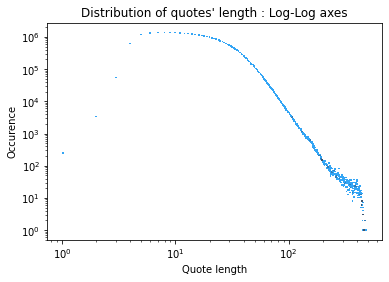

In [ ]:
path = drive+"/Distribution_plot/"+'all_years_counts_quote_length.csv'
data_length_all_years = pd.read_csv(path)
# Rename the columns for clarity 
data_length_all_years.columns = ["irrelevant", "x_vals", "y_vals"]
sns.histplot(data=data_length_all_years, x="x_vals", y="y_vals", log_scale=True, bins=400).set(title="Distribution of quotes' length : Log-Log axes", xlabel="Quote length", ylabel="Occurence")

In [ ]:
# Select the values between quote length of 30 and 100 (the part resembling a power law (linear trend on log-log plot))
#val_lin = dict_quote_len_year[2020].loc[30.0:100.0].reset_index()
val_lin = data_length_all_years.loc[30.0:100.0]
# Convert to logarithmic values
val_lin[["x_vals", "y_vals"]]= np.log(val_lin[["x_vals", "y_vals"]])
# Run a simple linear regression and check the slope or k the power law 
mod = smf.ols(formula='y_vals ~ x_vals', data=val_lin)
res = mod.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_vals   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     8740.
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           2.11e-74
Time:                        00:31:35   Log-Likelihood:                 45.537
No. Observations:                  71   AIC:                            -87.07
Df Residuals:                      69   BIC:                            -82.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.2712      0.190    148.761      0.000      27.892      28.650
x_vals        -4.2809      0.046    -93.485      0.000      -4.372      -4.190
==============================================================================
Omnibus:                       11.438   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.690
Skew:                          -0.941   Prob(JB):                      0.00289
Kurtosis:                       3.640   Cond. No.                         54.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Simple example on latimes, 2015, we can see that the median and mean only differ by 3
latimes_2015 = load_csv_to_df(2015, "latimes.com")
latimes_2015["quote_length"].describe()

count    152197.000000
mean         18.232041
std          13.306025
min           2.000000
25%           9.000000
50%          15.000000
75%          23.000000
max         368.000000
Name: quote_length, dtype: float64

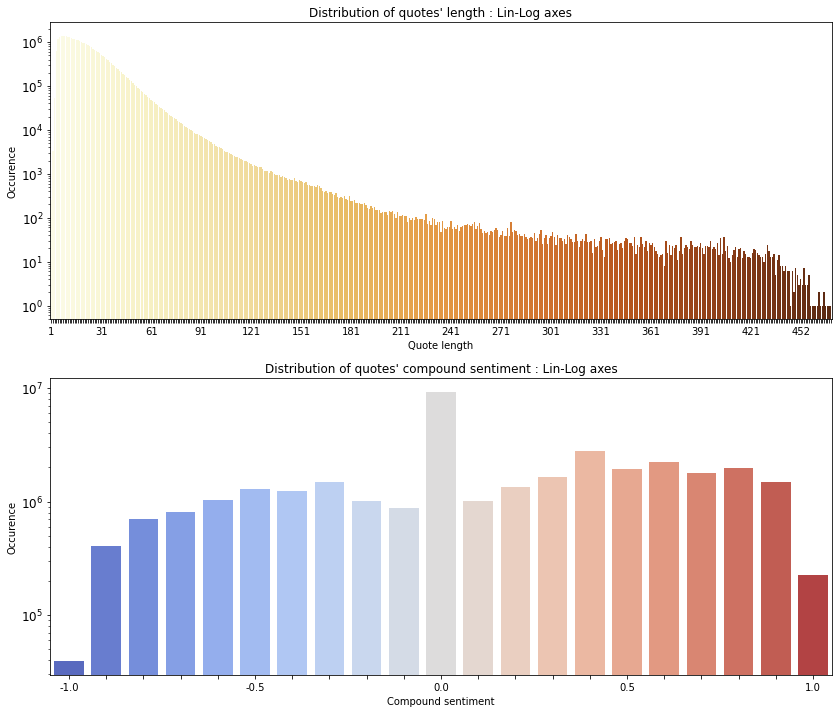

In [ ]:
# Plot for the quote's length
path = drive+"/Distribution_plot/"+'all_years_counts_quote_length.csv'
data_len = pd.read_csv(path)
_, axes = plt.subplots(2,1,figsize=(14,12))
sns.barplot(x="length", y="occurence", data=data_len, palette="YlOrBr", ax=axes[0])
axes[0].set(title="Distribution of quotes' length : Lin-Log axes", xlabel="Quote length", ylabel="Occurence")
# Reduce the number of x-ticks of 10%  
for ind, label in enumerate(axes[0].get_xticklabels()):
    if ind % 30 == 0:  # every 30th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

axes[0].set_yticklabels(axes[0].get_yticks(), size = 12)
axes[0].set_yscale("log")

# Plot for the quote's compound sentiment 
path = drive+"/Distribution_plot/"+'all_years_counts_quote_compound.csv'
data_com = pd.read_csv(path)
#_, ax2 = plt.subplots(figsize=(9,6))
sns.barplot(x="compound", y="occurence", data=data_com, palette="coolwarm", ax=axes[1])
axes[1].set(title="Distribution of quotes' compound sentiment : Lin-Log axes", xlabel="Compound sentiment", ylabel="Occurence")
# Reduce the number of x-ticks of 10%  
for ind, label in enumerate(axes[1].get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 12)
axes[1].set_yscale("log")

In [ ]:
# Distribution plot of quote length per year with a slider
fig = go.Figure()
fig.update_layout(
    title="Quote length distribution for year (Lin-Log axes): 2015",
    title_x=0.5,
)
# Add traces, one for each slider step
for year in list_years:
  # Load the data
  path = drive+"/Distribution_plot/"+str(year)+'_counts_quote_length.csv'
  data_len = pd.read_csv(path)
  data_len.columns = ["length", "occurence"]
  # Plot the data  
  fig.add_trace(
      go.Bar(
          visible=False,
          name="Year = " + str(year),
          x=data_len["length"],
          y=data_len["occurence"]))
  #fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log", row=1, col=2)
  fig.update_yaxes(type="log")

# Make 10th trace visible
fig.data[2].visible = True

# Create and add slider
steps = []
#for i in range(len(fig.data)):
for i, year in enumerate(list_years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Quote length distribution for year (Lin-Log axes): " + str(year)}],
        label = str(year),
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    xaxis_title="Mean quote length",
    yaxis_title="Occurence (Log scale)",
    sliders=sliders
)

fig.show()
fig.write_html(drive+"plotly html/E_0.html")

In [ ]:
# Distribution plot of quote compound sentiment per year with a slider
fig = go.Figure()
fig.update_layout(
    title="Compound sentiment distribution for year (Lin-Log axes): 2015",
    title_x=0.5,
)
# Add traces, one for each slider step
for year in list_years:
  # Load the data
  path = drive+"/Distribution_plot/"+str(year)+'_counts_quote_compound.csv'
  data_len = pd.read_csv(path)
  data_len.columns = ["compound", "occurence"]
  # Plot the data  
  fig.add_trace(
      go.Bar(
          visible=False,
          name="Year = " + str(year),
          x=data_len["compound"],
          y=data_len["occurence"]))
  #fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log", row=1, col=2)
  fig.update_yaxes(type="log")

# Make 10th trace visible
fig.data[2].visible = True

# Create and add slider
steps = []
#for i in range(len(fig.data)):
for i, year in enumerate(list_years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Quote length distribution for year (Lin-Log axes): " + str(year)}],
        label = str(year),
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    xaxis_title="Mean compound sentiment (Log scale)",
    yaxis_title="Occurence",
    sliders=sliders
)

fig.show()
fig.write_html(drive+"plotly html/E_1.html")

###1) Evolution of quoting style (2015-2020)

**Disclaimer for datastory -> put it right after the data story introduction**

In our study, we use two quote parameters to describe quoting style: length (number of words) and polarity score (the higher, the more positive). Our study uses only keep US news outlets that were in the top 200 news outlets with the most quotes each year, and produce their own content. All website political orientation were taken manually from the website Media Bias/Fact Check. (https://mediabiasfactcheck.com/).

**Additional info for notebook only**

In order to avoid any bias/error coming from a simple mean of mean (Simpson's paradox), we keep the number of quotes per outlet per year to compute a weighted mean and standard error of the mean (SEM). All plots display the mean, with SEM as errorbars. The error bars are too small to be visible, which means that observable differences are significant. 

**Intro part 1**

We first want to determine the evolution of quoting style of the selected news outlets between 2015 and 2020. The analysis is first performed for all news outlets, before separating them according to their political orientation (left-leaning, right-leaning and neutral).



In [ ]:
fig = go.Figure()

for outlet in list_domains:
  fig.add_trace(go.Scatter(x=time_scale,
                           y=df_means_length[outlet].values,
                           name=outlet,
                           mode = "lines",
                           line=dict(color='grey', width=1),
                           showlegend=False,
                           hoverlabel=dict(bgcolor='grey')))

fig.add_trace(go.Scatter(x=time_scale,
                         y=length_mean,
                         mode="lines",
                         name="Total mean",
                         line=dict(color='blue', width=4),
                         error_y=dict(type='data', array=np.round(length_error,6),color="black"),
                         hoverlabel=dict(bgcolor='blue')))

fig.update_layout(
    title="Evolution of mean quote length",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Mean quote length")

fig.show()
fig.write_html('1.1.html')

Here we show the distribution of mean quote length per outlet per year. We see that apart from a few outliers, it stays between 18 and 22 words. The mean quote length for all news outlets increased from 20 to 21 words between 2015 and 2020.

In [ ]:
fig = go.Figure()

for outlet in list_domains:
  fig.add_trace(go.Scatter(x=time_scale,
                           y=df_means_compound[outlet].values,
                           name=outlet,
                           mode = "lines",
                           line=dict(color='grey', width=1),
                           showlegend=False,
                           hoverlabel=dict(bgcolor='grey')))

fig.add_trace(go.Scatter(x=time_scale,
                         y=compound_mean,
                         mode="lines",
                         name="Total mean",
                         line=dict(color='blue', width=4),
                         error_y=dict(type='data', array=np.round(compound_error,6),color="black"),
                         hoverlabel=dict(bgcolor='blue')))

fig.update_layout(
    title="Evolution of mean quote polarity",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Mean polarity score")

fig.show()
fig.write_html('1.2.html')

This shows that news outlets have on average slightly positive quotes (polarity score >0). However this positivity has been following a negative trend between 2015 and 2020.

*Interestingly, there seems be two distinct populations, one below the average (0.07 to 0.11) and another above it (0.125 to 0.16). 
Could these groups correspond to news outlets of different political orientations?*


In [ ]:
all_selected_doms.dropna(subset=["Political_leaning"]).head()

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
0,nzherald.co.nz,1,1,NZ,0.0,1,NaN,5.0
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
5,inquisitr.com,1,0,UK,-1.0,0,NaN,3.0
6,brisbanetimes.com.au,1,1,AU,-1.0,1,NaN,NaN


Next, we divided the news outlets in three groups based on their political orientation : Left-leaning, Right-leaning and Neutral (no difference is made within a group, meaning no degrees of left or right). *This should allow us to determine if the 2 populations we observed correspond to the political leaning of the news outlet.*

In [ ]:
#Compute the difference in the quote mean length of left and right-leaning news sources
length_mean_difference= list()
for item_length_right, item_length_left in zip(length_mean_right, length_mean_left):
  length_mean_difference.append(item_length_right - item_length_left)
df_length_dif= pd.DataFrame(length_mean_difference)
df_length_dif.columns = ['Length Difference']
mean_length_dif =  df_length_dif[1:].agg(['mean', 'std'])
print(mean_length_dif)

      Length Difference
mean           1.340521
std            0.117789


In [ ]:
fig = go.Figure()
# Left-leaning news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=length_mean_left,
                         mode="lines",
                         name="Left-leaning news outlets",
                         line=dict(color='blue', width=4),
                         error_y=dict(type='data', array=np.round(length_error_left,6),color="black")))

# Neutral news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=length_mean_neutral,
                         mode="lines",
                         name="Neutral news outlets",
                         line=dict(color='green', width=4),
                         error_y=dict(type='data', array=np.round(length_error_neutral,6),color="black")))

# Right-leaning news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=length_mean_right,
                         mode="lines",
                         name="Right-leaning news outlets",
                         line=dict(color='red', width=4),
                         error_y=dict(type='data', array=np.round(length_error_right,6),color="black")))

# Average
fig.add_trace(go.Scatter(x=time_scale,
                         y=length_mean,
                         mode="lines",
                         name="Total mean",
                         line=dict(color='black', width=4),
                         error_y=dict(type='data', array=np.round(length_error,6),color="black")))

fig.update_layout(
    title="Evolution of quote mean length for news outlets of different political orientations",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Mean quote length"
    )

fig.show()
fig.write_html('1.3.html')

Right-leaning news outlets have a higher mean quote length than left-leaning ones for all years. Between 2016 and 2020, the difference between left and right-leaning news outlets' mean quote length stays constant at about 1.3 word.

Furthermore, they both follow the same evolution as the average mean quote length. This suggests the increase of quote length in news outlets is a general pattern which is independant political orientation.

*This graph seems to support the idea of different quoting style between left-leaning and right-leaning news outlets. Let's do the same with polarity score and see if our theory holds.*

Additionally the neutral websites have a higher than average mean quote length. We can hypothesize that the sharp decrease of quote length between 2015 and 2016 in right-leaning media may be related to the election.



In [ ]:
fig = go.Figure()
# Left-leaning news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=compound_mean_left,
                         mode="lines",
                         name="Left-leaning news outlets",
                         line=dict(color='blue', width=4),
                         error_y=dict(type='data', array=np.round(compound_error_left,6),color="black")))

# Neutral news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=compound_mean_neutral,
                         mode="lines",
                         name="Neutral news outlets",
                         line=dict(color='green', width=4),
                         error_y=dict(type='data', array=np.round(compound_error_neutral,6),color="black")))

# Right-leaning news outlets
fig.add_trace(go.Scatter(x=time_scale,
                         y=compound_mean_right,
                         mode="lines",
                         name="Right-leaning news outlets",
                         line=dict(color='red', width=4),
                         error_y=dict(type='data', array=np.round(compound_error_right,6),color="black")))

# Average
fig.add_trace(go.Scatter(x=time_scale,
                         y=compound_mean,
                         mode="lines",
                         name="Total mean",
                         line=dict(color='black', width=4),
                         error_y=dict(type='data', array=np.round(compound_error,6),color="black")))

fig.update_layout(
    title="Evolution of quote mean polarity score for news outlets of different political orientations",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Mean polarity score"
    )

fig.show()
fig.write_html('1.4.html')

Left-leaning news outlets's quotes are more positive than right-leaning news outlets across all years. Left-leaning news outlets's positivity increased between 2015 and 2020, while right-leaning news outlets stayed more or less constant. Neutral news outlets changed the most, their quote mean polarity score decreased from 0.15 to 0.11.

*We don't see left-leaning on one side of the mean and right-leaning on the other as we had hypothesized. However, there is still a notable difference in the polarity score of left and right-leaning news outlets, which supports our thesis for different quoting styles between right and left-leaning news outlets.*

*What if we combine left-leaning and neutral news outlets, maybe we get the 2 observed populations? we would have to plot both the polarity and the length to see how it holds*

**Conclusion part 1**

This yearly analysis of quoting style has yielded several inputs. 
Between 2015 and 2020, quotes have on average been getting longer (20.2 to 21.2 words), are generally positive but are getting less positive (0.128 to 0.116 polarity score).

*Looking at differences in the quoting styles of left and right-leaning news sources, we found that left-leaning news outlets have on average shorter and more positive quotes than right-leaning outlets.*

### 2) Quoting style according to political orientation

**Intro part 2**

*Dwelving deeper into this difference in quoting habits, we were interested in assessing if left/right-leaning news sources quote Democrat and Republican speakers differently. For example, would left-leaning news outlets quote Democratic speakers more (more and longer quotes) and more positively?*

For this analysis we decided to focus only on the most quoted Democrats and Republicans within the previously selected news outlets. Find out more about the selection process in our notebook.

In [ ]:
X = ['Left-leaning','Neutral','Right-leaning']

# Vector containing the number of quotes of Democrat speakers
Dem = [df_speakers_stats_total_dem["L_Count"].values[0],df_speakers_stats_total_dem["N_Count"].values[0],df_speakers_stats_total_dem["R_Count"].values[0]]
# Vector containing the number of quotes of Republican speakers
Rep = [df_speakers_stats_total_rep["L_Count"].values[0],df_speakers_stats_total_rep["N_Count"].values[0],df_speakers_stats_total_rep["R_Count"].values[0]]

# We define the values as ratio over the total number of quote:

Dem_ratio = Dem/np.array(Dem).sum()
Rep_ratio = Rep/np.array(Rep).sum()


fig = go.Figure()

fig.add_trace(go.Bar(
    name='Democrats',
    x=X, y=np.round(Dem_ratio,4)
))

fig.add_trace(go.Bar(
    name='Republicans',
    x=X, y=np.round(Rep_ratio,4)
))

fig.update_layout(
    title="Distribution of Republican and Democrat quotes with respect to news outlet leaning",
    title_x=0.5,
    xaxis_title="News outlet political leaning",
    yaxis_title="Quoting percentage"
    )

fig.show()
fig.write_html('2_1.html')

Surprisingly, quotes from Democratic and Republican speakers are very closely distributed between the different news outlets. There is only a bit more of the quotes from Democratic speakers in left-leaning news oulets, and a bit more of the quotes from Republican speakers in right-leaning news oulets (about 1%).

*It seems like there is not much difference in how much websites of different political leaning quote Democratic or Republican speakers. Let's see if instead there is one in the way they quote !*



**Known bias :**

- 70% of republican quotes in total dataset
- Majority of left leaning outlets

In [ ]:
X = ['Left-leaning','Neutral','Right-leaning']
Dem = [df_speakers_stats_total_dem["L_Len"].values[0],df_speakers_stats_total_dem["N_Len"].values[0],df_speakers_stats_total_dem["R_Len"].values[0]]
Rep = [df_speakers_stats_total_rep["L_Len"].values[0],df_speakers_stats_total_rep["N_Len"].values[0],df_speakers_stats_total_rep["R_Len"].values[0]]

Dem_err = [df_speakers_stats_total_dem["L_Len_err"].values[0],df_speakers_stats_total_dem["N_Len_err"].values[0],df_speakers_stats_total_dem["R_Len_err"].values[0]]
Rep_err = [df_speakers_stats_total_rep["L_Len_err"].values[0],df_speakers_stats_total_rep["N_Len_err"].values[0],df_speakers_stats_total_rep["R_Len_err"].values[0]]



fig = go.Figure()

fig.add_trace(go.Bar(
    name='Democrats',
    x=X, y=np.round(Dem,4),
    error_y=dict(type='data', array=np.round(Dem_err,6))
))

fig.add_trace(go.Bar(
    name='Republicans',
    x=X, y=np.round(Rep,4),
    error_y=dict(type='data', array=np.round(Rep_err,6))
))

fig.update_layout(
    title="Mean quote length with respect to speaker and news outlet political orientation",
    title_x=0.5,
    xaxis_title="News outlet political leaning",
    yaxis_title="Mean quote length"
    )

fig.update_yaxes(range = [15,23])

fig.show()
fig.write_html('2_2.html')

This plot shows that speakers affiliated to the Democratic party have on average longer quotes than speakers affiliated to the Republican party (by 1-2 words), in neutral, left, and right-leaning news outlets. 

Furthermore, and in accordance to our previous results, we find that there is a difference in mean quoting length between left-leaning, neutral and right-leaning news outlets, with left leaning outlets using shorter quotes and right leaning outlets using longer ones.

*Democrat speakers have longer quotes than Republicans, independent of the leaning of the news outlet. Let's now look at the quote positivity.*

In [ ]:
X = ['Left-leaning','Neutral','Right-leaning']
Dem = [df_speakers_stats_total_dem["L_Pol"].values[0],df_speakers_stats_total_dem["N_Pol"].values[0],df_speakers_stats_total_dem["R_Pol"].values[0]]
Rep = [df_speakers_stats_total_rep["L_Pol"].values[0],df_speakers_stats_total_rep["N_Pol"].values[0],df_speakers_stats_total_rep["R_Pol"].values[0]]

Dem_err = [df_speakers_stats_total_dem["L_Pol_err"].values[0],df_speakers_stats_total_dem["N_Pol_err"].values[0],df_speakers_stats_total_dem["R_Pol_err"].values[0]]
Rep_err = [df_speakers_stats_total_rep["L_Pol_err"].values[0],df_speakers_stats_total_rep["N_Pol_err"].values[0],df_speakers_stats_total_rep["R_Pol_err"].values[0]]



fig = go.Figure()

fig.add_trace(go.Bar(
    name='Democrats',
    x=X, y=np.round(Dem,4),
    error_y=dict(type='data', array=np.round(Dem_err,6))
))

fig.add_trace(go.Bar(
    name='Republicans',
    x=X, y=np.round(Rep,4),
    error_y=dict(type='data', array=np.round(Rep_err,6))
))

fig.update_layout(
    title="Mean polarity score with respect to speaker and news outlet political orientation",
    title_x=0.5,
    xaxis_title="News outlet political leaning",
    yaxis_title="Mean polarity score"
    )

fig.update_yaxes(range = [0.05,0.08])

fig.show()
fig.write_html('2_3.html')

First, left-leaning news outlet quote Democrats more positively than Republicans, and right-leaning news outlets quote Republicans more positively than Democrats. *Therefore we observe the expected pattern where news outlets quote the speakers from their own political orientation more positively those from the opposite one.*

Second, Democratic speaker are quoted more positively in left-leaning news outlets than in right-leaning news outlets and Republican speakers are quoted more positively in right-leaning news-outlets than in left-leaning news outlets. *More surprisingly, neutral news outlets quote more positively than politicized news outlets, for both Republican and Democratic speakers. This indicates that a more negative quoting style is associated with politicized news outlets.*

Third, we observed that the polarity score of the most quoted speakers belonging to any of the two main US parties is lower than mean polarity score for all speakers found in the first part of the analysis. 

*Therefore we've found that politically oriented top speakers are quoted more negatively on average than either less quoted political speakers or apolitical speakers. Let's look into this more, are apolitical speakers quoted more positively, or could it be that the top speakers are actually quoted more negatively than less quoted speakers?*

In [ ]:
X = ['Democratic','Republican',"Apolitical"]
L = [df_speakers_stats_total_dem["L_Pol"].values[0],df_speakers_stats_total_rep["L_Pol"].values[0]] # Mean polarity score in left-leaning news outlet
N = [df_speakers_stats_total_dem["N_Pol"].values[0],df_speakers_stats_total_rep["N_Pol"].values[0]] # Mean polarity score in nautral news outlet
R = [df_speakers_stats_total_dem["R_Pol"].values[0],df_speakers_stats_total_rep["R_Pol"].values[0]] # Mean polarity score in right-leaning news outlet
Dem_count = [df_speakers_stats_total_dem["L_Count"].values[0],df_speakers_stats_total_dem["N_Count"].values[0],df_speakers_stats_total_dem["R_Count"].values[0]] # Quotes count for democrat speakers
Rep_count = [df_speakers_stats_total_rep["L_Count"].values[0],df_speakers_stats_total_rep["N_Count"].values[0],df_speakers_stats_total_rep["R_Count"].values[0]] # Quotes count for republican speakers

Dem_mean = np.average(np.array([L[0],N[0],R[0]]),weights=np.array(Dem_count)) # Compute the weighted mean for Democrat speakers
Rep_mean = np.average(np.array([L[1],N[1],R[1]]),weights=np.array(Rep_count)) # Compute the weighted mean for Republican speakers
# Weighted mean for Apolitic speakers is already computed : compound_mean_apo

total_mean_pol = (Dem_mean*15 + Rep_mean*15 + compound_mean_apo*(75-8-30))/(75-8) # Compute the weighted mean for Apolitical speakers


fig = go.Figure()

fig.add_trace(go.Bar(
    x=["Democrats"], y=[np.round(Dem_mean,4)],
    width=0.4
))

fig.add_trace(go.Bar(
    x=["Republicans"], y=[np.round(Rep_mean,4)],
    width=0.4
))

fig.add_trace(go.Bar(
    x=["Apolitical"], y=[np.round(compound_mean_apo,4)],
    width=0.4,
    marker_color='LightSlateGrey'
))

fig.update_layout(
    title="Mean polarity score with respect to speaker political orientation",
    title_x=0.5,
    xaxis_title="Speaker political orientation",
    yaxis_title="Mean polarity score",
    hoverlabel=dict(namelength=0)
    )

fig.add_hline(y=total_mean_pol,
              line=dict(dash="dash"))
fig.update_layout(showlegend=False)
fig.show()
fig.write_html('2_4.html')

Following our discovery that the top political speakers had less positive quotes than the average, we decided to compare quotes from top democrat, republican and apolitical speakers. 
We observe that top apolitical speakers have almost 3 times the polarity score of top Democratic or Republican speakers.

*Therefore we indeed have this pattern where, amongst the top speakers, apolitical speakers' quotes are 3x more positive !*

We also see that on average, the top speakers (here) have more positive quotes than standard speakers (previous analysis).

*Here we must reject our hypothesis that top speakers are on average quoted more negatively than less quoted speakers. It seems that low positivity of top political speakers is more than compensated by the high positivity of top apolitical speakers.*

**Conclusion part 2**

*Democrat and Republican quotes are similarly distributed amongst news outlets of different political leaning. Democrats have longer quotes in all of them. News outlets quote the speakers from their own political orientation more positively than those from the opposite one. Finally, we've seen that politicised news outlets and politicised speakers both lead to generally more negative quotes. It looks like politics is just more negative overall...*

### 3) Quoting style according to news source factual reporting

**Intro part 3**

*We've observed a quoting style difference between left and right-leaning news outlets. However this division according to political leaning does not explain all the quoting style variation. Therefore we decided to group news outlets according to a new parameter: their factual reporting rating. Our hypothesis is that news outlets with higher factual reporting would keep longer and more neutral (less positive) quotes. We are also interested in determining whether neutral website have higher factual reporting than politicized news outlets.*

Among the websites we are assessing, the factual reporting rating ranges from mixed to high.

In [ ]:
X = ['Mixed','Mostly','High']
Mi = [df_speakers_stats_total_dem_FR["Mi_Len"].values[0],df_speakers_stats_total_rep_FR["Mi_Len"].values[0]] # Mean quote length in Mixed factual reporting news outlet
Mo = [df_speakers_stats_total_dem_FR["Mo_Len"].values[0],df_speakers_stats_total_rep_FR["Mo_Len"].values[0]] # Mean quote length in Mostly factual reporting news outlet
Hi = [df_speakers_stats_total_dem_FR["Hi_Len"].values[0],df_speakers_stats_total_rep_FR["Hi_Len"].values[0]] # Mean quote length in High factual reporting news outlet

# Quotes number for speakers of both parties
Dem_count = [df_speakers_stats_total_dem_FR["Mi_Count"].values[0],df_speakers_stats_total_dem_FR["Mo_Count"].values[0],df_speakers_stats_total_dem_FR["Hi_Count"].values[0]]
Rep_count = [df_speakers_stats_total_rep_FR["Mi_Count"].values[0],df_speakers_stats_total_rep_FR["Mo_Count"].values[0],df_speakers_stats_total_rep_FR["Hi_Count"].values[0]]

Mi_mean = (Mi[0]*Dem_count[0] + Mi[1]*Rep_count[0])/(Dem_count[0]+Rep_count[0])
Mo_mean = (Mo[0]*Dem_count[1] + Mo[1]*Rep_count[1])/(Dem_count[1]+Rep_count[1])
Hi_mean = (Hi[0]*Dem_count[2] + Hi[1]*Rep_count[2])/(Dem_count[2]+Rep_count[2])


fig = go.Figure()

fig.add_trace(go.Bar(
    x=["Mixed"], y=[np.round(Mi_mean,4)],
    width=0.4,
    marker_color='DarkMagenta'
))

fig.add_trace(go.Bar(
    x=["Mostly"], y=[np.round(Mo_mean,4)],
    width=0.4,
    marker_color='Orange'
))

fig.add_trace(go.Bar(
    x=["High"], y=[np.round(Hi_mean,4)],
    width=0.4,
    marker_color='Green'
))

fig.update_layout(
    title="Mean quote length with respect to news outlet factual reporting",
    title_x=0.5,
    xaxis_title="Factual reporting",
    yaxis_title="Mean quote length",
    hoverlabel=dict(namelength=0)
    )

fig.update_yaxes(range = [15,22])
fig.update_layout(showlegend=False)
fig.show()
fig.write_html('3_1.html')

Mixed and high factual reporting have mean quote length around 21 words, whereas mostly factual new outlets have a mean quote length of 18 words.

*We do not have our hypothesised linked increase of quote length and factual reporting.*

In [ ]:
X = ['Mixed','Mostly','High']
Mi = [df_speakers_stats_total_dem_FR["Mi_Pol"].values[0],df_speakers_stats_total_rep_FR["Mi_Pol"].values[0]] # Mean polarity score in Mixed factual reporting news outlet
Mo = [df_speakers_stats_total_dem_FR["Mo_Pol"].values[0],df_speakers_stats_total_rep_FR["Mo_Pol"].values[0]] # Mean polarity score in Mostly factual reporting news outlet
Hi = [df_speakers_stats_total_dem_FR["Hi_Pol"].values[0],df_speakers_stats_total_rep_FR["Hi_Pol"].values[0]] # Mean polarity score in High factual reporting news outlet

# Quotes number for speakers of both parties
Dem_count = [df_speakers_stats_total_dem_FR["Mi_Count"].values[0],df_speakers_stats_total_dem_FR["Mo_Count"].values[0],df_speakers_stats_total_dem_FR["Hi_Count"].values[0]]
Rep_count = [df_speakers_stats_total_rep_FR["Mi_Count"].values[0],df_speakers_stats_total_rep_FR["Mo_Count"].values[0],df_speakers_stats_total_rep_FR["Hi_Count"].values[0]]

Mi_mean = (Mi[0]*Dem_count[0] + Mi[1]*Rep_count[0])/(Dem_count[0]+Rep_count[0])
Mo_mean = (Mo[0]*Dem_count[1] + Mo[1]*Rep_count[1])/(Dem_count[1]+Rep_count[1])
Hi_mean = (Hi[0]*Dem_count[2] + Hi[1]*Rep_count[2])/(Dem_count[2]+Rep_count[2])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=["Mixed"], y=[np.round(Mi_mean,4)],
    width=0.4,
    marker_color='DarkMagenta'
))

fig.add_trace(go.Bar(
    x=["Mostly"], y=[np.round(Mo_mean,4)],
    width=0.4,
    marker_color='Orange'
))

fig.add_trace(go.Bar(
    x=["High"], y=[np.round(Hi_mean,4)],
    width=0.4,
    marker_color='Green'
))

fig.update_layout(
    title="Mean polarity score with respect to news outlet factual reporting",
    title_x=0.5,
    xaxis_title="Factual reporting",
    yaxis_title="Mean polarity score",
    hoverlabel=dict(namelength=0)
    )

fig.update_yaxes(range = [0.06,0.072])
fig.update_layout(showlegend=False)
fig.show()
fig.write_html('3_2.html')

Once again we have mixed and high factual reporting quite close together at around 0.069 and news outlets with mostly factual reporting at 0.066.

*Therefore quote positivity does not follow factual reporting in a linear fashion*

For the next plot we need to separate the oulets in three categories based on how far from neutrality they are : 
- Neutral (`Political_leaning` == 0)
- Left/Right-center (`Political_leaning` == +- 1)
- Extreme (abs(`Political_leaning`) > 1)

In [ ]:
politic_bias_list = []
for outlet in political_US_outlets.iterrows():
  if abs(outlet[1]["Political_leaning"]) >= 2:
    politic_bias_list.append("Extreme")
  elif abs(outlet[1]["Political_leaning"]) == 1:
    politic_bias_list.append("Left/Right-Center")
  elif outlet[1]["Political_leaning"] == 0:
    politic_bias_list.append("Neutral")

political_US_outlets["Political_bias"] = politic_bias_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:

fig = px.bar(data_frame=political_US_outlets.groupby(['Political_bias']).mean().reset_index(),
             x='Political_bias',
             y='Factual_reporting',
             category_orders={'Political_bias': ["Neutral","Left/Right-Center","Left/Right"]},
             color="Political_bias",
             color_discrete_sequence=['LightPink','Orchid','DarkOrchid'],
             error_y=political_US_outlets.groupby(['Political_bias']).sem().reset_index().Factual_reporting)

fig.update_layout(
     title="Mean factual reporting with respect to level of politicisation of news outlet",
    title_x=0.5,
    yaxis = dict(
        tickmode = 'array',
        tickvals = [1,2,3,4,5],
        ticktext = ['1', '2', 'Mixed = 3', 'Mostly = 4', 'High = 5']
        ),
     yaxis_title="Factual reporting",
     xaxis_title="Political bias"
)

fig.show()
fig.write_html('3.3.html')

Here we've separated our news outlet political leaning value with subvalues of left/right, differentiating between left/left-center and right/right-center. All center and extreme values were merged.

We see that very political websites have a lower factual reporting, and that neutral and left/right-center are indiscernable.

*It looks like going from neutral to a moderate political leaning does not impact the factual rating of news sources. However, having a very clear left/right political leaning is associated with a significantly lower factual reporting rating.*

**Conclusion part 3:**

*From what we've just seen, it doesn't look like variations in factual reporting and quoting style are really linked, or at least not in a linear way. 
However, we did confirm that very politicised websites have lower factual reporting than neutral or moderately politicised one.*

### 4) Principle component analysis


**Intro part 4:**

*Let's now turn things around and group news outlets by quoting style. We'll see if this grouping corresponds to the the previous groupings we used, namely political leaning and factual reporting.*

**Methodology: not for the datastory**

The idea is that we will input a twelve dimensions variable: 
- for each of the *six years* there will be the: 
  - `quote_length`
  - `polarity_score` 
  
This twelve degrees of freedom will hopefully be correlated with the `political_leaning` and `factual_reporting` of the given news outlet. Basically we will try to predict the political leaning and factual reporting based on `quote_length` and `polarity_score`. 

The first step is to gather the twelve variables into a dataframe, for this we will use `get_mean_of_col_for_each_outlet_per_year(col, list_of_outlets)`to compute the mean per year per outlet.
Then we compute the PCA and plot the different clusters based on political leaning and factual reporting. 

In [ ]:
# Initiate data frame with the list of the US political domains 
list_years = [2015, 2016, 2017, 2018, 2019, 2020]
# Initiate the columns names
tmp_len, tmp_com = [], [] 
for year in list_years:
  tmp_len.append(str(year)+"_len")
  tmp_com.append(str(year)+"_pol")
col_names = tmp_len + tmp_com
data_PCA = pd.DataFrame(index=list_domains, columns=col_names)
data_PCA.loc[:, tmp_len]  = get_mean_of_col_for_each_outlet_per_year("quote_length",list_domains).T.values
data_PCA.loc[:, tmp_com]  = get_mean_of_col_for_each_outlet_per_year("compound",list_domains).T.values

# For the Washington Post does not have values for 2020, so we remove it 
data_PCA.dropna(inplace=True)

,2015_len,2016_len,2017_len,2018_len,2019_len,2020_len,2015_pol,2016_pol,2017_pol,2018_pol,2019_pol,2020_pol
latimes.com,18.232,18.3967,18.9018,19.3386,19.7509,19.7487,0.125557,0.131786,0.130372,0.137327,0.129715,0.112225
breitbart.com,26.8044,20.88,20.8942,20.4744,20.8923,21.4522,0.0360819,0.0921929,0.094649,0.105469,0.0973902,0.0957404
wtop.com,18.7837,19.0276,19.1485,18.4826,18.867,19.225,0.159981,0.155056,0.148618,0.105848,0.100752,0.103291
chicagotribune.com,19.4026,19.2869,19.6891,20.1787,22.2875,20.3902,0.154172,0.142298,0.141398,0.14402,0.0997843,0.129555
sfgate.com,18.5135,18.7935,18.4644,18.6107,19.7097,20.8969,0.107689,0.107965,0.0960289,0.0983566,0.117968,0.130861
upi.com,22.2486,23.1041,23.2014,23.6882,22.5347,23.1222,0.177251,0.204579,0.218107,0.219165,0.176878,0.175097
chron.com,18.8817,20.4661,20.029,19.6682,19.0766,19.8882,0.129547,0.131929,0.155258,0.142485,0.112826,0.118946
cnn.com,19.656,19.8493,20.1161,20.8801,21.7093,22.124,0.0808692,0.0906861,0.086573,0.0833517,0.0815028,0.0950401
nytimes.com,12.119,17.5021,16.8576,16.6273,16.5985,16.8086,0.0473131,0.106861,0.0845212,0.0791975,0.0773883,0.0655321
thehill.com,20.9238,21.2247,21.5447,21.9834,22.6081,22.8167,0.0928928,0.0818648,0.0743337,0.0665419,0.0671745,0.0751038


In [ ]:
# Normalise the data between 0 and 1 
scaler = MinMaxScaler()
scaler.fit(data_PCA)
scaled = scaler.fit_transform(data_PCA)
data_PCA_scaled = pd.DataFrame(scaled, columns=data_PCA.columns)

,2015_len,2016_len,2017_len,2018_len,2019_len,2020_len,2015_pol,2016_pol,2017_pol,2018_pol,2019_pol,2020_pol
0,0.416269,0.102339,0.202993,0.383984,0.407556,0.368935,0.633814,0.454421,0.428176,0.463790,0.431012,0.350684
1,1.000000,0.386408,0.400828,0.544855,0.555128,0.582693,0.000000,0.157676,0.195346,0.255056,0.208237,0.226876
2,0.453837,0.174500,0.227485,0.262757,0.293286,0.303218,0.877661,0.628824,0.547097,0.257540,0.231409,0.283586
3,0.495981,0.204170,0.281171,0.502975,0.735510,0.449425,0.836515,0.533204,0.500041,0.507641,0.224736,0.480839
4,0.435435,0.147720,0.159559,0.280904,0.402236,0.513011,0.507246,0.275886,0.204340,0.208453,0.350051,0.490645
5,0.689777,0.640826,0.629935,1.000000,0.767474,0.792241,1.000000,1.000000,1.000000,1.000000,0.756039,0.822877
6,0.460509,0.339055,0.314920,0.430666,0.320386,0.386439,0.662078,0.455495,0.590374,0.497588,0.314614,0.401160
7,0.513230,0.268497,0.323563,0.602312,0.660764,0.666994,0.317259,0.146382,0.142710,0.110140,0.098746,0.221616
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079558,0.267614,0.129337,0.082921,0.070390,0.000000
9,0.599561,0.425831,0.465432,0.758564,0.776964,0.753910,0.402431,0.080268,0.062939,0.000000,0.000000,0.071887


In [ ]:
# Extract the color of the news outlet given the political leaning
# We need to drop the Washington post again 
political_US_outlets.drop(29, inplace=True)
# Create new column for the political leaning's color of the outlet, set it at grey 
political_US_outlets.loc[:,"color"] = "black"
# Define a mask excluding the neutral outlets 
mask = political_US_outlets["Political_leaning"]!=0
# Assign to red the right leaning outlets, blue the left leaning outlets 
political_US_outlets.loc[mask,"color"] = political_US_outlets.loc[mask,"Political_leaning"].apply(lambda x: "red" if x > 0 else "blue")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


**Compute the PCA and plot for the normalised data** 

In [ ]:
# Computing the PCA
pca = PCA(n_components=2)
X_r = pca.fit(data_PCA_scaled).transform(data_PCA_scaled)

For the next plot we need to separate the oulets in three categories based on their political leaning : 
- Left (`Political_leaning` < 0)
- Neutral (`Political_leaning` == 0)
- Right (`Political_leaning` > 0)

In [ ]:
politic_leaning_list = []
for outlet in political_US_outlets.iterrows():
  if outlet[1]["Political_leaning"] > 0:
    politic_leaning_list.append("Right")
  elif outlet[1]["Political_leaning"] == 0:
    politic_leaning_list.append("Neutral")
  elif outlet[1]["Political_leaning"] < 0:
    politic_leaning_list.append("Left")

political_US_outlets["Political_leaning_class"] = politic_leaning_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We also need to separate the oulets in three categories based on their factual reporting : 
- High (`Factual_reporting` == 5)
- Mostly (`Factual_reporting` == 4)
- Mixed (`Factual_reporting` == 3)

In [ ]:
factual_reporting_list = []
for outlet in political_US_outlets.iterrows():
  if outlet[1]["Factual_reporting"] == 5:
    factual_reporting_list.append("High")
  elif outlet[1]["Factual_reporting"] == 4:
    factual_reporting_list.append("Mostly")
  elif outlet[1]["Factual_reporting"] == 3:
    factual_reporting_list.append("Mixed")

political_US_outlets["Factual_reporting_class"] = factual_reporting_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
temp_PUO = political_US_outlets
temp_PUO["PCA_1"]=X_r[0:,0]
temp_PUO["PCA_2"]=X_r[0:,1]


fig = px.scatter(data_frame=temp_PUO,
             x='PCA_1',
             y='PCA_2',
             color="Political_leaning_class")
fig.update_traces(marker_size=10)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
temp_PUO = political_US_outlets
temp_PUO["PCA_1"]=X_r[0:,0]
temp_PUO["PCA_2"]=X_r[0:,1]


fig = px.scatter(data_frame=temp_PUO,
             x='PCA_1',
             y='PCA_2',
             color="Factual_reporting_class")
fig.update_traces(marker_size=10)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Although there are not two distinct clusters of right and left-leaning news outlets, we can draw a line that separates them accurately. Therefore there seems to indeed be a difference in the quoting style of left and right leaning news outlets.



**Conclusion part 4**
Neither political leaning nor factual reporting rating completely account for the differences in factual reporting.


### 5) Conclusion and outlook

**Conclusion**

Combiner les conclusions des 3 parties + dire que le political leaning ca permet de mieux grouper les quoting style que le factual reporting.

**Autre chose?**

**OUTLOOK**

**A ajuster, j'ai écrit cette partie après avoir fait la partie 1 il y a genre 1 semaine, donc y'a sans doute des trucs qui ont changé**

For analysis, we assesed the quoting style according to political leaning of speakers and news outlets between 2015 and 2020. However we believe that the elections (ie who is in power) will directly impact how major political players are quoted. We hypothesize the party in power will on average be quoted more, and in more negative terms because of the higher impact the party has on people's life.

To confirm this hypothesis, it would be necessary to divide the analysis by presidential mendate periods (2012-2016, 2016-2020, 2020-present day) and assess whether there is an inversion in quote mean polarity score for Democratic and Republican speakers (and maybe length).

****

Another possible analysis would be to look at whether news outlets with a political orientation quote speakers with the same political orientation more positively in the months leading up to an election. Building on this idea, we could assess try to detect the bias of officially neutral news outlets by looking at the difference in the way they quote political candidates before an election (for example using US governors and senators).